In [ ]:
!pip install segmentation-models-pytorch

1. Import necessary packages/libraries:

In [3]:
import numpy as np
import torch
import torchvision
import cv2
import time
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import itertools
import os
import albumentations as A
import pickle

from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import normalize
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
from PIL import Image
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    RandomRotate90,
    RandomBrightnessContrast,
    Compose
)

2. Load, understand, and visualize the dataset:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Paths to point to dataset location
train_data_path = '/content/drive/MyDrive/Cam101/train'
test_data_path = '/content/drive/MyDrive/Cam101/test'

# Load the dataset
train_images = sorted([os.path.join(train_data_path, f) for f in os.listdir(train_data_path) if not f.endswith('_L.png')])
train_labels = sorted([os.path.join(train_data_path, f) for f in os.listdir(train_data_path) if f.endswith('_L.png')])
test_images = sorted([os.path.join(test_data_path, f) for f in os.listdir(test_data_path) if not f.endswith('_L.png')])
test_labels = sorted([os.path.join(test_data_path, f) for f in os.listdir(test_data_path) if f.endswith('_L.png')])

> 2.1. Print the number of training and testing samples in the dataset:

In [5]:
# Print the number of training and testing samples
print(f"Number of training samples: {len(train_images)}")
print(f"Number of testing samples: {len(test_images)}")

Number of training samples: 90
Number of testing samples: 11


> 2.2. Plot some figures to visualize a few samples from the dataset:

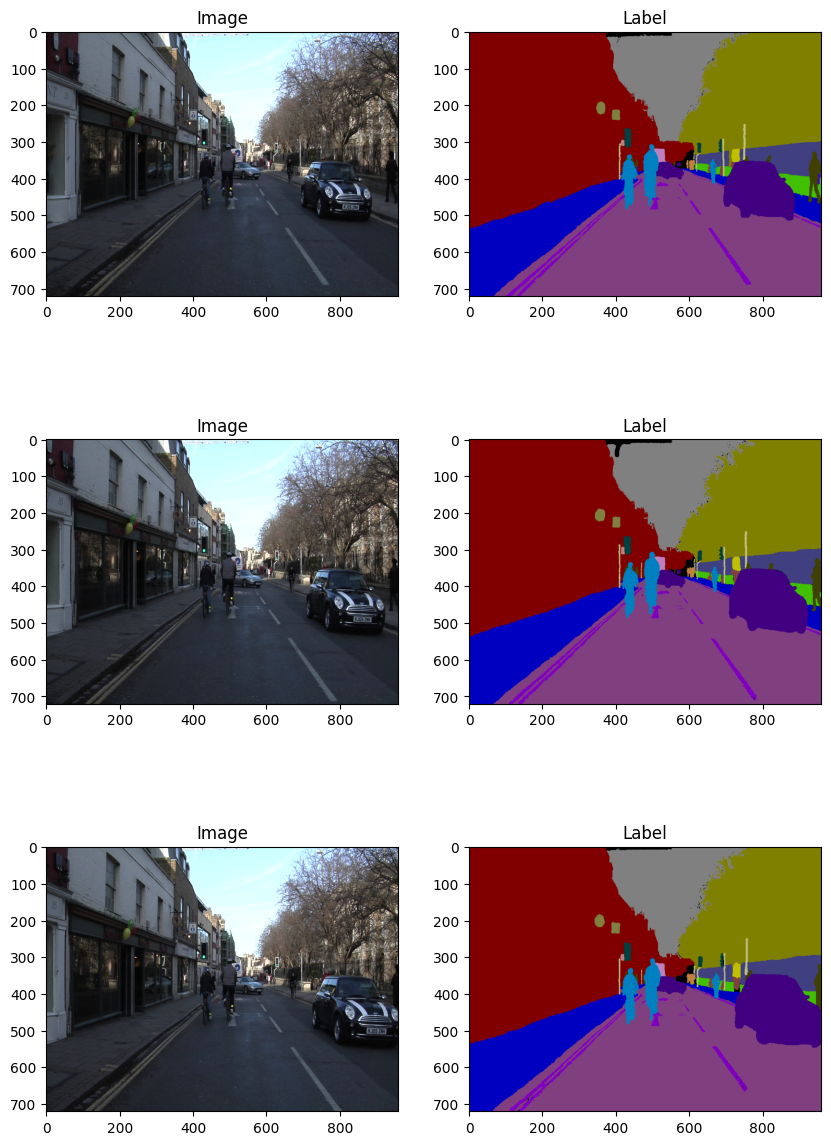

In [6]:
# Visualize a few samples from the dataset
num_samples = 3

fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))

for i in range(num_samples):
    # Load and display the image
    img = Image.open(train_images[i])
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Image')

    # Load and display the corresponding label
    lbl = Image.open(train_labels[i])
    axes[i, 1].imshow(lbl)
    axes[i, 1].set_title('Label')

plt.show()

3. Explore and apply data augmentation techniques to expand the training dataset:

In [7]:
def apply_augmentation(image, label, augmentations):
    augmented = augmentations(image=image, mask=label)
    return augmented['image'], augmented['mask']

# Define the augmentation pipeline
augmentations = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomRotate90(p=0.5),
    RandomBrightnessContrast(p=0.3),
])

# Apply augmentations to the training dataset
train_images_augmented = []
train_labels_augmented = []

for image_path, label_path in zip(train_images, train_labels):
    # Load the image and label
    image = np.array(Image.open(image_path))
    label = np.array(Image.open(label_path))

    # Apply the augmentations
    image_augmented, label_augmented = apply_augmentation(image, label, augmentations)

    # Store the augmented images and labels
    train_images_augmented.append(image_augmented)
    train_labels_augmented.append(label_augmented)

4. Split the augmented training dataset into a training set (90%) and a validation set (10%). Create a pipeline for training, validation, and testing datasets:

In [8]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Resize the image and label to the same fixed size
        fixed_size = (480, 320)
        image = cv2.resize(image, fixed_size)
        label = cv2.resize(label, fixed_size)

        # Convert the label image to a single-channel tensor representing the class index
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        class_index_map = {(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4,
                          (64, 0, 128): 5, (64, 0, 192): 6, (192, 128, 64): 7, (192, 192, 128): 8, (64, 64, 128): 9,
                          (128, 0, 192): 10, (192, 0, 64): 11, (128, 128, 64): 12, (192, 0, 192): 13, (128, 64, 64): 14,
                          (64, 192, 128): 15, (64, 64, 0): 16, (128, 64, 128): 17, (128, 128, 192): 18, (0, 0, 192): 19,
                          (192, 128, 128): 20, (128, 128, 128): 21, (64, 128, 192): 22, (0, 0, 64): 23, (0, 64, 64): 24,
                          (192, 64, 128): 25, (128, 128, 0): 26, (192, 128, 192): 27, (64, 0, 64): 28, (192, 192, 0): 29,
                          (0, 0, 0): 30, (64, 192, 0): 31}
        label_index = np.zeros(label.shape[:2], dtype=np.uint8)
        for rgb, index in class_index_map.items():
            label_index[(label == rgb).all(axis=2)] = index

        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        image = normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        label_index = torch.tensor(label_index).long()

        return image, label_index


class CustomTestDataset(CustomDataset):
    def __init__(self, image_paths, label_paths):
        images = []
        labels = []

        for image_path, label_path in zip(image_paths, label_paths):
            # Load the image and label
            image = np.array(Image.open(image_path))
            label = np.array(Image.open(label_path))

            images.append(image)
            labels.append(label)

        super().__init__(images, labels)


# Split the augmented dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images_augmented, train_labels_augmented, test_size=0.1, random_state=42
)


# Create custom datasets
train_dataset = CustomDataset(train_images, train_labels)
val_dataset = CustomDataset(val_images, val_labels)
test_dataset = CustomTestDataset(test_images, test_labels)


# Create DataLoaders for the training, validation, and testing datasets
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

5. Train, Evaluate and Plot Metrics functions

In [9]:
def train_and_evaluate(model, train_loader, val_loader, epochs, learning_rate, optimizer, device, model_name, scheduler_option):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    scaler = GradScaler()

    train_losses = []
    val_losses = []
    mean_ious = []
    pixel_accuracies = []

    start_time = time.time()
    epsilon = 1e-8

    best_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_train_loss += loss.item()

        scheduler.step()
        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_val_loss = 0.0
        n_classes = 32
        confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                # Calculate mean IoU and pixel accuracy
                pred = outputs.detach().max(1)[1].cpu().numpy()
                gt = labels.cpu().numpy()

                for p, t in zip(pred, gt):
                    mask = (t >= 0) & (t < n_classes)
                    confusion_matrix += np.bincount(n_classes * t[mask].astype(int) + p[mask], minlength=n_classes ** 2).reshape(n_classes, n_classes)

        val_losses.append(running_val_loss / len(val_loader))

        intersection = np.diag(confusion_matrix)
        union = confusion_matrix.sum(axis=1) + confusion_matrix.sum(axis=0) - intersection
        iou = intersection / (union + 1e-8)
        pixel_acc = intersection.sum() / confusion_matrix.sum()

        mean_ious.append(np.nanmean(iou))
        pixel_accuracies.append(np.nanmean(pixel_acc))

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save(model.state_dict(), f"best_model_{model_name}.pth")

        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'Train loss: {train_losses[-1]:.4f} | Validation loss: {val_losses[-1]:.4f}')
        print(f'Mean IoU: {mean_ious[-1]:.4f} | Pixel accuracy: {pixel_accuracies[-1]:.4f}')

    end_time = time.time()
    print(f'Training time: {end_time - start_time:.2f} seconds')

    plot_metrics(train_losses, val_losses, mean_ious, pixel_accuracies)

    best_mean_iou = max(mean_ious)
    print(f'Best Mean IoU: {best_mean_iou:.4f}')
    
    return best_mean_iou    


def plot_metrics(train_losses, val_losses, mean_ious, pixel_accuracies):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(mean_ious, label='Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('Mean IoU')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(pixel_accuracies, label='Pixel Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Pixel Accuracy')
    plt.legend()

    plt.show()

> 5.1.

*   Train and Evaluate UNet model
*   Explore best hyperparameters



Training and evaluating unet with the following hyperparameters:
  Encoder: resnet50 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:17<00:00,  2.95s/it]


Epoch 1/10
Train loss: 3.5283 | Validation loss: 3.4480
Mean IoU: 0.0018 | Pixel accuracy: 0.0083


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 2/10
Train loss: 3.2920 | Validation loss: 3.4838
Mean IoU: 0.0019 | Pixel accuracy: 0.0056


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 3/10
Train loss: 3.1597 | Validation loss: 3.5153
Mean IoU: 0.0030 | Pixel accuracy: 0.0104


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 4/10
Train loss: 3.0509 | Validation loss: 3.4671
Mean IoU: 0.0042 | Pixel accuracy: 0.0200


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 5/10
Train loss: 2.9362 | Validation loss: 3.2712
Mean IoU: 0.0086 | Pixel accuracy: 0.0965


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 6/10
Train loss: 2.8712 | Validation loss: 2.9630
Mean IoU: 0.0181 | Pixel accuracy: 0.2586


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 7/10
Train loss: 2.8683 | Validation loss: 2.8402
Mean IoU: 0.0230 | Pixel accuracy: 0.3307


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 8/10
Train loss: 2.8543 | Validation loss: 2.7976
Mean IoU: 0.0251 | Pixel accuracy: 0.3557


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 9/10
Train loss: 2.8392 | Validation loss: 2.7870
Mean IoU: 0.0261 | Pixel accuracy: 0.3616


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 10/10
Train loss: 2.8321 | Validation loss: 2.7869
Mean IoU: 0.0266 | Pixel accuracy: 0.3586
Training time: 159.40 seconds


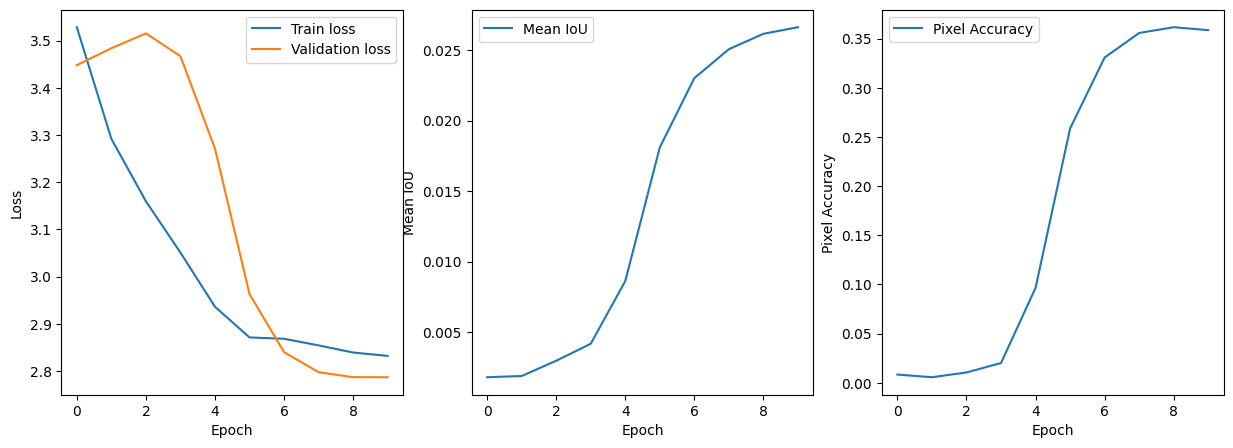

Best Mean IoU: 0.0266
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 1/10
Train loss: 3.3920 | Validation loss: 3.3851
Mean IoU: 0.0133 | Pixel accuracy: 0.1605


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 2/10
Train loss: 3.0692 | Validation loss: 3.2084
Mean IoU: 0.0116 | Pixel accuracy: 0.2505


100%|██████████| 6/6 [00:11<00:00,  2.00s/it]


Epoch 3/10
Train loss: 2.9114 | Validation loss: 3.1018
Mean IoU: 0.0149 | Pixel accuracy: 0.2602


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch 4/10
Train loss: 2.7774 | Validation loss: 3.0347
Mean IoU: 0.0317 | Pixel accuracy: 0.3242


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 5/10
Train loss: 2.6573 | Validation loss: 2.9204
Mean IoU: 0.0307 | Pixel accuracy: 0.3316


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 6/10
Train loss: 2.5752 | Validation loss: 2.7494
Mean IoU: 0.0391 | Pixel accuracy: 0.3698


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 7/10
Train loss: 2.5512 | Validation loss: 2.6622
Mean IoU: 0.0463 | Pixel accuracy: 0.4107


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 8/10
Train loss: 2.5307 | Validation loss: 2.6208
Mean IoU: 0.0505 | Pixel accuracy: 0.4375


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 9/10
Train loss: 2.5226 | Validation loss: 2.5893
Mean IoU: 0.0536 | Pixel accuracy: 0.4606


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 10/10
Train loss: 2.5149 | Validation loss: 2.5593
Mean IoU: 0.0561 | Pixel accuracy: 0.4805
Training time: 157.51 seconds


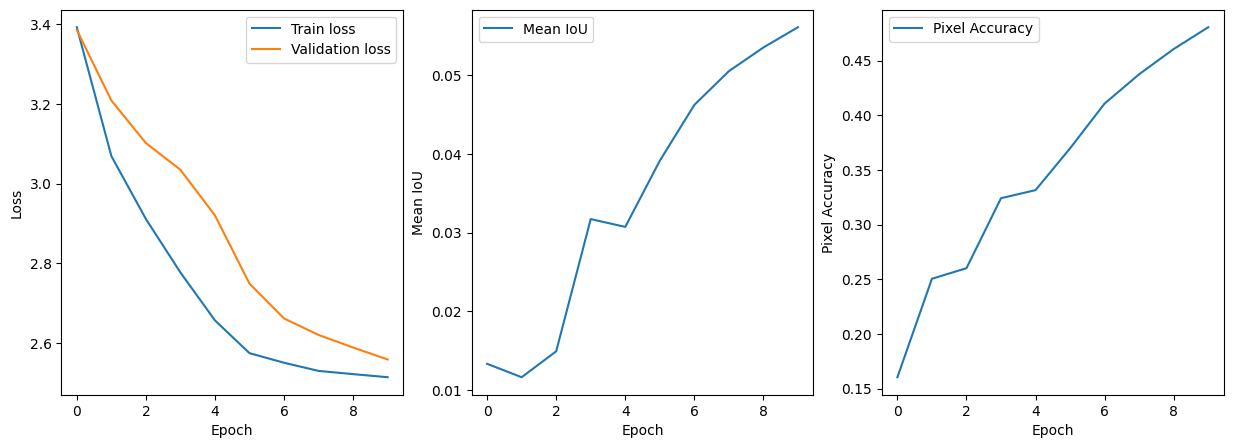

Best Mean IoU: 0.0561

Best encoder_name: resnet101 | Mean IoU: 0.056143887898567085

Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 1/10
Train loss: 3.4574 | Validation loss: 3.4519
Mean IoU: 0.0134 | Pixel accuracy: 0.1865


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 2/10
Train loss: 3.2052 | Validation loss: 3.4328
Mean IoU: 0.0125 | Pixel accuracy: 0.2232


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 3/10
Train loss: 3.0448 | Validation loss: 3.3279
Mean IoU: 0.0126 | Pixel accuracy: 0.2339


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 4/10
Train loss: 2.8904 | Validation loss: 3.2451
Mean IoU: 0.0139 | Pixel accuracy: 0.2462


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 5/10
Train loss: 2.7745 | Validation loss: 3.0750
Mean IoU: 0.0330 | Pixel accuracy: 0.3120


100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch 6/10
Train loss: 2.7233 | Validation loss: 2.8716
Mean IoU: 0.0424 | Pixel accuracy: 0.3784


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 7/10
Train loss: 2.7127 | Validation loss: 2.7917
Mean IoU: 0.0478 | Pixel accuracy: 0.4162


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 8/10
Train loss: 2.7124 | Validation loss: 2.7831
Mean IoU: 0.0500 | Pixel accuracy: 0.4261


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 9/10
Train loss: 2.6810 | Validation loss: 2.7186
Mean IoU: 0.0536 | Pixel accuracy: 0.4566


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 10/10
Train loss: 2.6832 | Validation loss: 2.6952
Mean IoU: 0.0556 | Pixel accuracy: 0.4684
Training time: 156.21 seconds


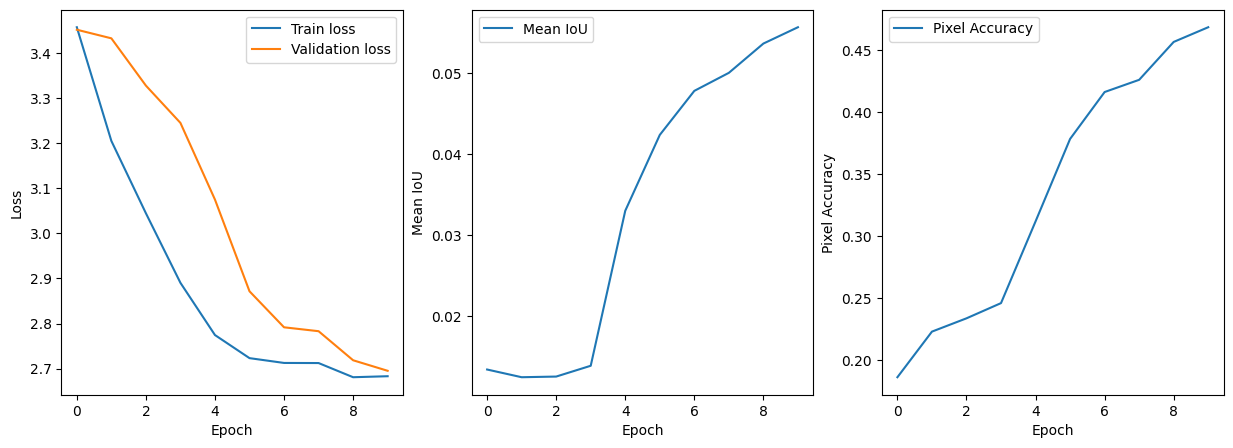

Best Mean IoU: 0.0556
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 50.9MB/s]
100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 1/10
Train loss: 3.2069 | Validation loss: 3.2668
Mean IoU: 0.0190 | Pixel accuracy: 0.0776


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 2/10
Train loss: 2.9372 | Validation loss: 3.0315
Mean IoU: 0.0372 | Pixel accuracy: 0.2038


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 3/10
Train loss: 2.7788 | Validation loss: 2.8185
Mean IoU: 0.0477 | Pixel accuracy: 0.3172


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 4/10
Train loss: 2.6518 | Validation loss: 2.6192
Mean IoU: 0.0564 | Pixel accuracy: 0.4505


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch 5/10
Train loss: 2.5506 | Validation loss: 2.5239
Mean IoU: 0.0654 | Pixel accuracy: 0.5761


100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Epoch 6/10
Train loss: 2.4893 | Validation loss: 2.5206
Mean IoU: 0.0687 | Pixel accuracy: 0.5894


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 7/10
Train loss: 2.4816 | Validation loss: 2.5088
Mean IoU: 0.0708 | Pixel accuracy: 0.5956


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 8/10
Train loss: 2.4707 | Validation loss: 2.5017
Mean IoU: 0.0725 | Pixel accuracy: 0.6076


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 9/10
Train loss: 2.4629 | Validation loss: 2.4944
Mean IoU: 0.0740 | Pixel accuracy: 0.6221


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 10/10
Train loss: 2.4528 | Validation loss: 2.4825
Mean IoU: 0.0744 | Pixel accuracy: 0.6250
Training time: 157.22 seconds


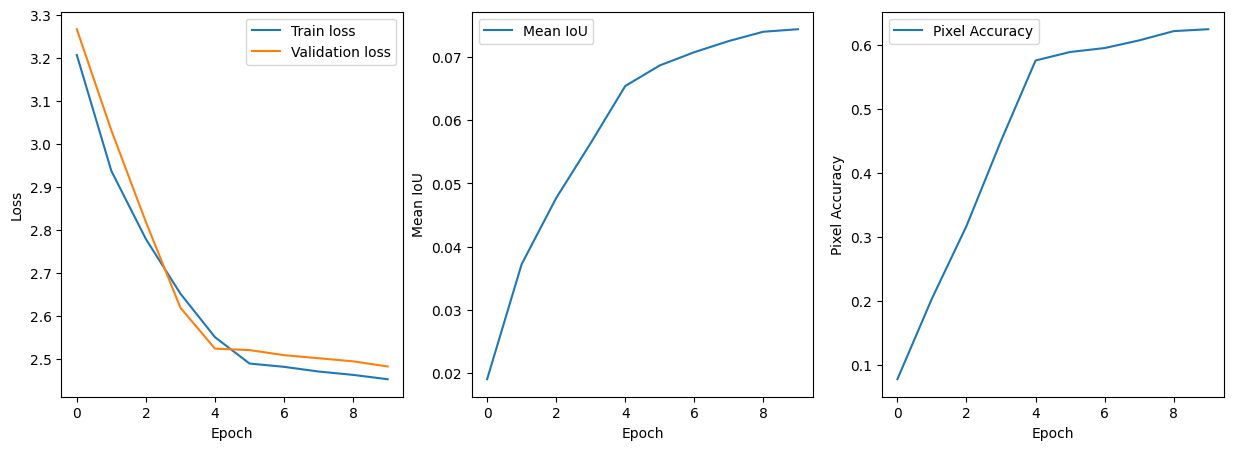

Best Mean IoU: 0.0744

Best encoder_weights: imagenet | Mean IoU: 0.0743974399575731

Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 1/10
Train loss: 3.2645 | Validation loss: 3.3676
Mean IoU: 0.0154 | Pixel accuracy: 0.0679


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch 2/10
Train loss: 2.9102 | Validation loss: 3.1277
Mean IoU: 0.0383 | Pixel accuracy: 0.2758


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch 3/10
Train loss: 2.7240 | Validation loss: 2.8638
Mean IoU: 0.0478 | Pixel accuracy: 0.3975


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch 4/10
Train loss: 2.5864 | Validation loss: 2.6358
Mean IoU: 0.0570 | Pixel accuracy: 0.5087


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 5/10
Train loss: 2.4725 | Validation loss: 2.4855
Mean IoU: 0.0632 | Pixel accuracy: 0.5894


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 6/10
Train loss: 2.4119 | Validation loss: 2.4630
Mean IoU: 0.0645 | Pixel accuracy: 0.6264


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 7/10
Train loss: 2.3955 | Validation loss: 2.4427
Mean IoU: 0.0655 | Pixel accuracy: 0.6438


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 8/10
Train loss: 2.3804 | Validation loss: 2.4215
Mean IoU: 0.0668 | Pixel accuracy: 0.6603


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 9/10
Train loss: 2.3782 | Validation loss: 2.4044
Mean IoU: 0.0675 | Pixel accuracy: 0.6700


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 10/10
Train loss: 2.3717 | Validation loss: 2.3938
Mean IoU: 0.0673 | Pixel accuracy: 0.6742
Training time: 163.07 seconds


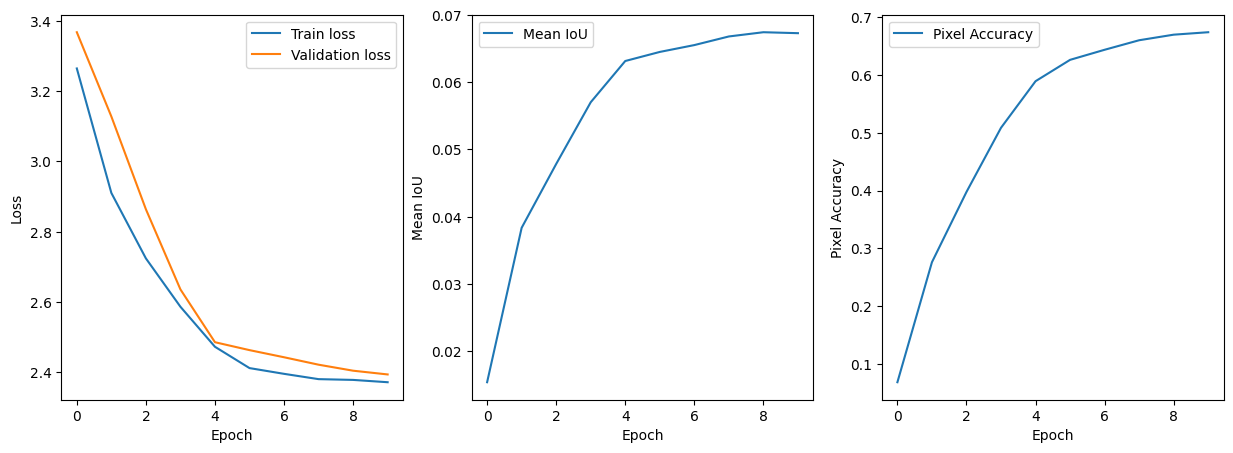

Best Mean IoU: 0.0675
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch 1/10
Train loss: 3.3971 | Validation loss: 3.4412
Mean IoU: 0.0180 | Pixel accuracy: 0.1037


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 2/10
Train loss: 3.3198 | Validation loss: 3.3231
Mean IoU: 0.0290 | Pixel accuracy: 0.2596


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch 3/10
Train loss: 3.2773 | Validation loss: 3.2729
Mean IoU: 0.0329 | Pixel accuracy: 0.3206


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 4/10
Train loss: 3.2485 | Validation loss: 3.2478
Mean IoU: 0.0599 | Pixel accuracy: 0.5805


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 5/10
Train loss: 3.2262 | Validation loss: 3.2341
Mean IoU: 0.0730 | Pixel accuracy: 0.6742


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 6/10
Train loss: 3.2113 | Validation loss: 3.2288
Mean IoU: 0.0754 | Pixel accuracy: 0.6924


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 7/10
Train loss: 3.2080 | Validation loss: 3.2237
Mean IoU: 0.0762 | Pixel accuracy: 0.7009


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 8/10
Train loss: 3.2080 | Validation loss: 3.2202
Mean IoU: 0.0762 | Pixel accuracy: 0.7016


100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


Epoch 9/10
Train loss: 3.2028 | Validation loss: 3.2172
Mean IoU: 0.0772 | Pixel accuracy: 0.7114


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 10/10
Train loss: 3.2024 | Validation loss: 3.2149
Mean IoU: 0.0773 | Pixel accuracy: 0.7136
Training time: 159.32 seconds


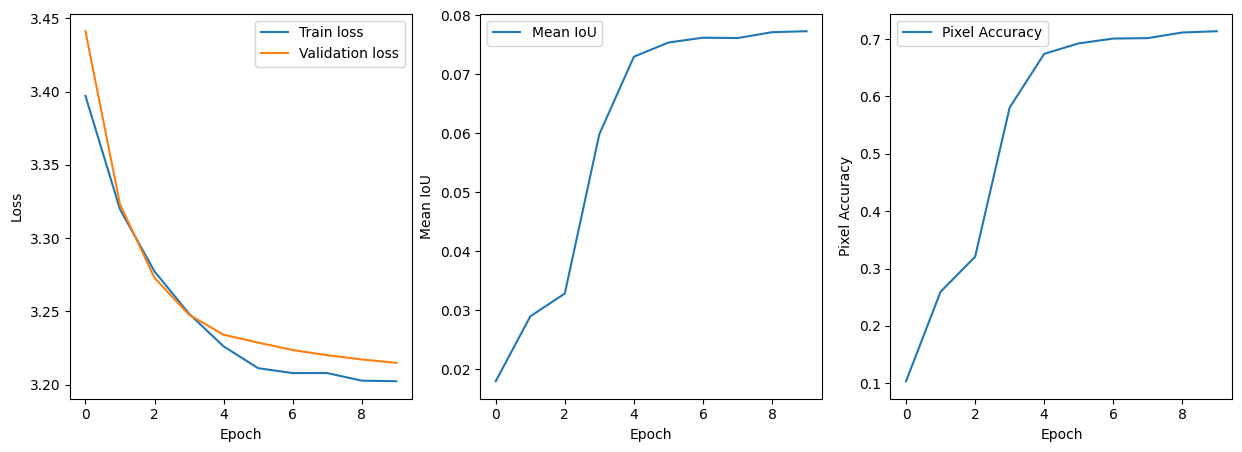

Best Mean IoU: 0.0773
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: softmax2d
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 1/10
Train loss: 3.4624 | Validation loss: 3.4579
Mean IoU: 0.0101 | Pixel accuracy: 0.0509


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 2/10
Train loss: 3.4441 | Validation loss: 3.4196
Mean IoU: 0.0304 | Pixel accuracy: 0.1766


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 3/10
Train loss: 3.4307 | Validation loss: 3.4009
Mean IoU: 0.0366 | Pixel accuracy: 0.2301


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch 4/10
Train loss: 3.4177 | Validation loss: 3.3797
Mean IoU: 0.0418 | Pixel accuracy: 0.2398


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 5/10
Train loss: 3.4027 | Validation loss: 3.3709
Mean IoU: 0.0479 | Pixel accuracy: 0.2774


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 6/10
Train loss: 3.3939 | Validation loss: 3.3871
Mean IoU: 0.0467 | Pixel accuracy: 0.2628


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 7/10
Train loss: 3.3909 | Validation loss: 3.3911
Mean IoU: 0.0474 | Pixel accuracy: 0.2733


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 8/10
Train loss: 3.3895 | Validation loss: 3.3923
Mean IoU: 0.0473 | Pixel accuracy: 0.2741


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 9/10
Train loss: 3.3872 | Validation loss: 3.3894
Mean IoU: 0.0488 | Pixel accuracy: 0.2928


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 10/10
Train loss: 3.3851 | Validation loss: 3.3897
Mean IoU: 0.0474 | Pixel accuracy: 0.2772
Training time: 157.73 seconds


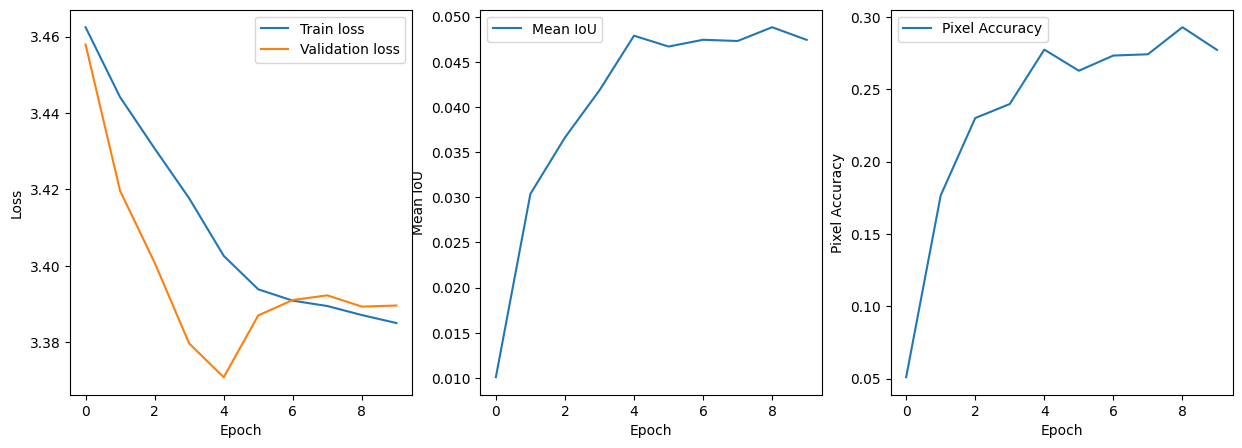

Best Mean IoU: 0.0488

Best activation: sigmoid | Mean IoU: 0.07733123521257781

Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 1/10
Train loss: 3.3468 | Validation loss: 3.4047
Mean IoU: 0.0384 | Pixel accuracy: 0.3032


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch 2/10
Train loss: 3.2965 | Validation loss: 3.3514
Mean IoU: 0.0444 | Pixel accuracy: 0.3430


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch 3/10
Train loss: 3.2640 | Validation loss: 3.2864
Mean IoU: 0.0485 | Pixel accuracy: 0.3788


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 4/10
Train loss: 3.2392 | Validation loss: 3.2421
Mean IoU: 0.0519 | Pixel accuracy: 0.4258


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch 5/10
Train loss: 3.2169 | Validation loss: 3.2138
Mean IoU: 0.0565 | Pixel accuracy: 0.5184


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch 6/10
Train loss: 3.2050 | Validation loss: 3.2070
Mean IoU: 0.0596 | Pixel accuracy: 0.5742


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 7/10
Train loss: 3.2036 | Validation loss: 3.2038
Mean IoU: 0.0604 | Pixel accuracy: 0.5954


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 8/10
Train loss: 3.1986 | Validation loss: 3.2001
Mean IoU: 0.0611 | Pixel accuracy: 0.6100


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 9/10
Train loss: 3.1995 | Validation loss: 3.1955
Mean IoU: 0.0618 | Pixel accuracy: 0.6220


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 10/10
Train loss: 3.1966 | Validation loss: 3.1932
Mean IoU: 0.0623 | Pixel accuracy: 0.6310
Training time: 162.71 seconds


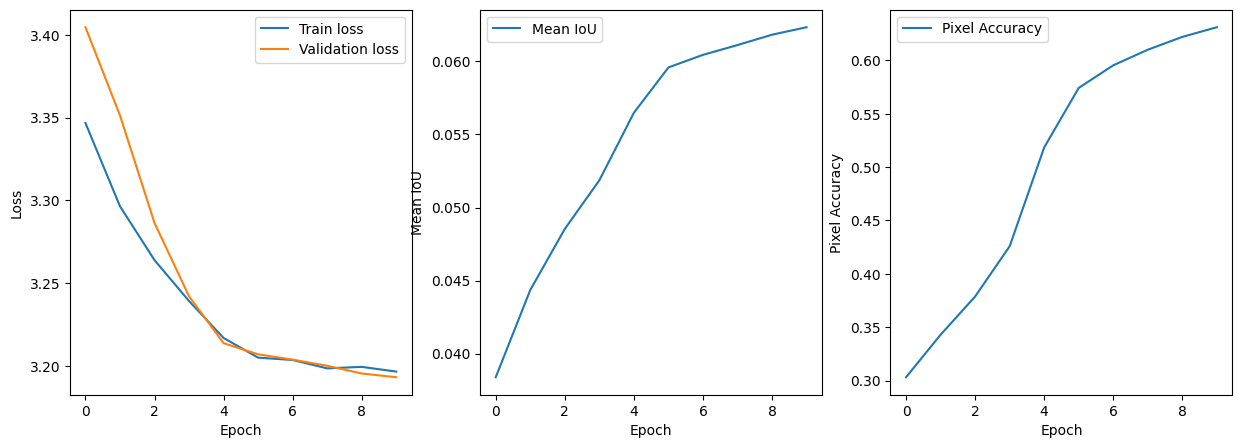

Best Mean IoU: 0.0623
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 5e-05 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:14<00:00,  2.33s/it]


Epoch 1/10
Train loss: 3.3917 | Validation loss: 3.4340
Mean IoU: 0.0053 | Pixel accuracy: 0.0459


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 2/10
Train loss: 3.3440 | Validation loss: 3.3873
Mean IoU: 0.0150 | Pixel accuracy: 0.0976


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 3/10
Train loss: 3.3125 | Validation loss: 3.3329
Mean IoU: 0.0248 | Pixel accuracy: 0.1935


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 4/10
Train loss: 3.2861 | Validation loss: 3.2936
Mean IoU: 0.0356 | Pixel accuracy: 0.2904


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 5/10
Train loss: 3.2689 | Validation loss: 3.2690
Mean IoU: 0.0491 | Pixel accuracy: 0.3810


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 6/10
Train loss: 3.2560 | Validation loss: 3.2643
Mean IoU: 0.0539 | Pixel accuracy: 0.3991


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 7/10
Train loss: 3.2546 | Validation loss: 3.2627
Mean IoU: 0.0557 | Pixel accuracy: 0.4017


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 8/10
Train loss: 3.2544 | Validation loss: 3.2616
Mean IoU: 0.0576 | Pixel accuracy: 0.4097


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 9/10
Train loss: 3.2518 | Validation loss: 3.2617
Mean IoU: 0.0579 | Pixel accuracy: 0.4128


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


Epoch 10/10
Train loss: 3.2506 | Validation loss: 3.2598
Mean IoU: 0.0584 | Pixel accuracy: 0.4175
Training time: 160.49 seconds


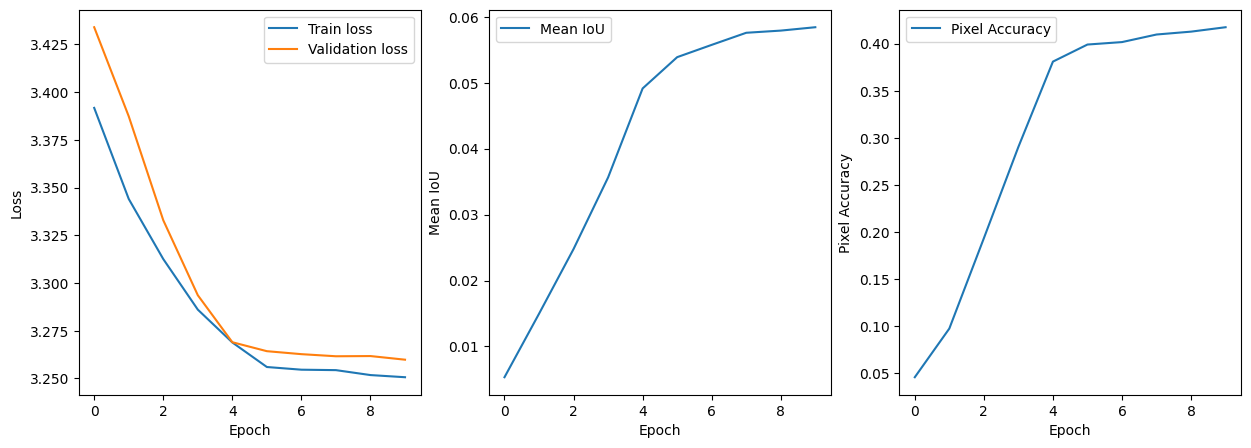

Best Mean IoU: 0.0584

Best learning_rate: 0.0001 | Mean IoU: 0.0623379921938199

Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 1/10
Train loss: 3.5442 | Validation loss: 3.5320
Mean IoU: 0.0042 | Pixel accuracy: 0.0139


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 2/10
Train loss: 3.4706 | Validation loss: 3.4936
Mean IoU: 0.0059 | Pixel accuracy: 0.0155


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 3/10
Train loss: 3.4382 | Validation loss: 3.4546
Mean IoU: 0.0086 | Pixel accuracy: 0.0187


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 4/10
Train loss: 3.4066 | Validation loss: 3.4232
Mean IoU: 0.0098 | Pixel accuracy: 0.0292


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 5/10
Train loss: 3.3794 | Validation loss: 3.3910
Mean IoU: 0.0171 | Pixel accuracy: 0.1372


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Epoch 6/10
Train loss: 3.3612 | Validation loss: 3.3768
Mean IoU: 0.0259 | Pixel accuracy: 0.2632


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 7/10
Train loss: 3.3574 | Validation loss: 3.3689
Mean IoU: 0.0324 | Pixel accuracy: 0.3392


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 8/10
Train loss: 3.3536 | Validation loss: 3.3633
Mean IoU: 0.0365 | Pixel accuracy: 0.3881


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 9/10
Train loss: 3.3495 | Validation loss: 3.3601
Mean IoU: 0.0386 | Pixel accuracy: 0.4128


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 10/10
Train loss: 3.3463 | Validation loss: 3.3555
Mean IoU: 0.0416 | Pixel accuracy: 0.4458
Training time: 161.58 seconds


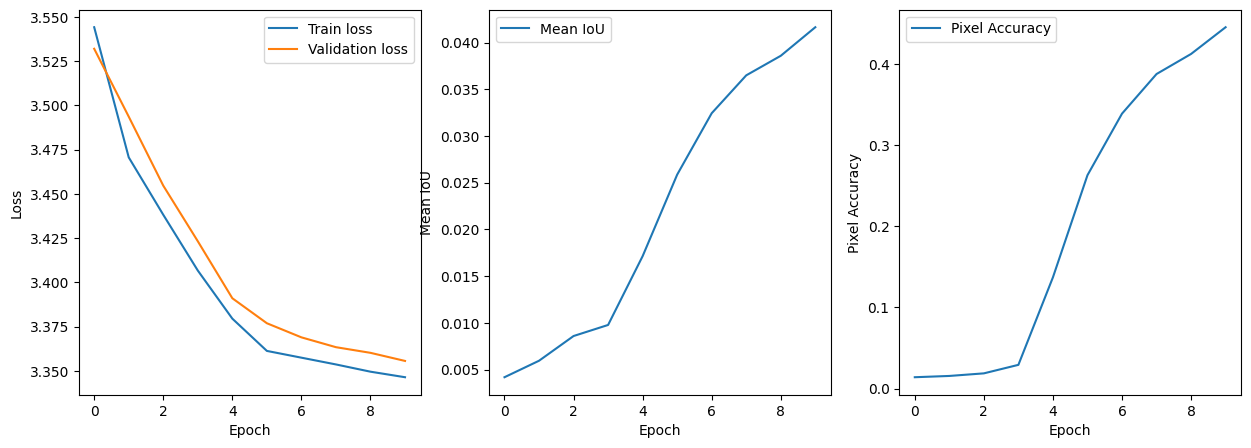

Best Mean IoU: 0.0416
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: SGD | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 1/10
Train loss: 3.4003 | Validation loss: 3.4503
Mean IoU: 0.0062 | Pixel accuracy: 0.0699


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 2/10
Train loss: 3.3440 | Validation loss: 3.4060
Mean IoU: 0.0126 | Pixel accuracy: 0.1882


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch 3/10
Train loss: 3.3111 | Validation loss: 3.3545
Mean IoU: 0.0195 | Pixel accuracy: 0.3084


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 4/10
Train loss: 3.2840 | Validation loss: 3.3056
Mean IoU: 0.0268 | Pixel accuracy: 0.3980


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 5/10
Train loss: 3.2621 | Validation loss: 3.2703
Mean IoU: 0.0345 | Pixel accuracy: 0.4683


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 6/10
Train loss: 3.2484 | Validation loss: 3.2611
Mean IoU: 0.0394 | Pixel accuracy: 0.4990


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Epoch 7/10
Train loss: 3.2458 | Validation loss: 3.2532
Mean IoU: 0.0422 | Pixel accuracy: 0.5191


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 8/10
Train loss: 3.2436 | Validation loss: 3.2511
Mean IoU: 0.0431 | Pixel accuracy: 0.5231


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 9/10
Train loss: 3.2398 | Validation loss: 3.2467
Mean IoU: 0.0440 | Pixel accuracy: 0.5295


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 10/10
Train loss: 3.2390 | Validation loss: 3.2458
Mean IoU: 0.0445 | Pixel accuracy: 0.5314
Training time: 161.50 seconds


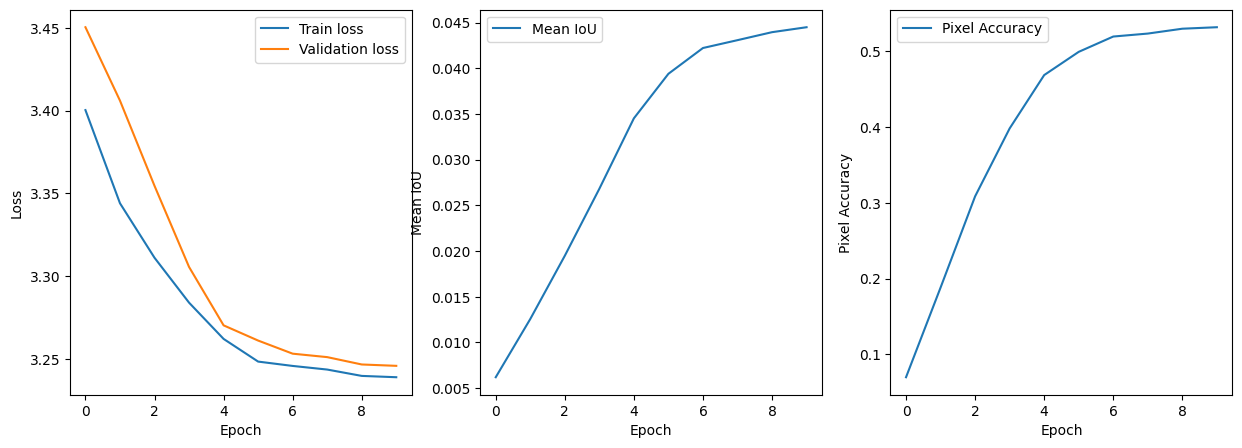

Best Mean IoU: 0.0445
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: RMSprop | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 1/10
Train loss: 3.4826 | Validation loss: 3.4784
Mean IoU: 0.0012 | Pixel accuracy: 0.0037


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 2/10
Train loss: 3.4270 | Validation loss: 3.4269
Mean IoU: 0.0027 | Pixel accuracy: 0.0390


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 3/10
Train loss: 3.3919 | Validation loss: 3.3877
Mean IoU: 0.0063 | Pixel accuracy: 0.1039


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 4/10
Train loss: 3.3615 | Validation loss: 3.3430
Mean IoU: 0.0124 | Pixel accuracy: 0.2185


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 5/10
Train loss: 3.3327 | Validation loss: 3.3186
Mean IoU: 0.0162 | Pixel accuracy: 0.2866


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 6/10
Train loss: 3.3151 | Validation loss: 3.3122
Mean IoU: 0.0171 | Pixel accuracy: 0.3032


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 7/10
Train loss: 3.3138 | Validation loss: 3.3098
Mean IoU: 0.0175 | Pixel accuracy: 0.3106


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 8/10
Train loss: 3.3120 | Validation loss: 3.3054
Mean IoU: 0.0177 | Pixel accuracy: 0.3157


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 9/10
Train loss: 3.3075 | Validation loss: 3.3007
Mean IoU: 0.0182 | Pixel accuracy: 0.3245


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 10/10
Train loss: 3.3073 | Validation loss: 3.3004
Mean IoU: 0.0184 | Pixel accuracy: 0.3275
Training time: 159.65 seconds


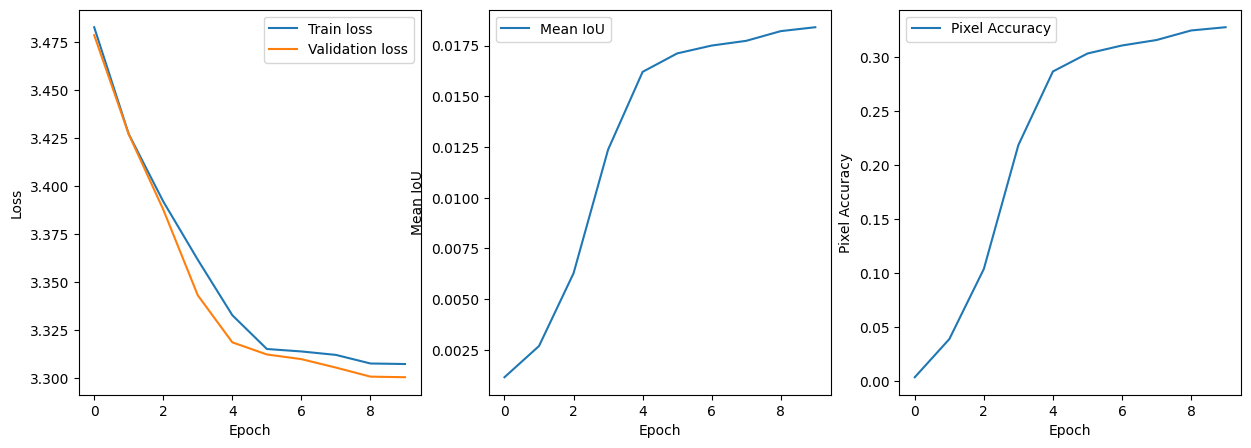

Best Mean IoU: 0.0184

Best optimizer: <class 'torch.optim.sgd.SGD'> | Mean IoU: 0.044500533168306065

Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: SGD | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 1/10
Train loss: 3.4595 | Validation loss: 3.4520
Mean IoU: 0.0069 | Pixel accuracy: 0.0495


100%|██████████| 6/6 [00:12<00:00,  2.17s/it]


Epoch 2/10
Train loss: 3.3901 | Validation loss: 3.4168
Mean IoU: 0.0070 | Pixel accuracy: 0.0616


100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


Epoch 3/10
Train loss: 3.3581 | Validation loss: 3.3687
Mean IoU: 0.0144 | Pixel accuracy: 0.1136


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 4/10
Train loss: 3.3361 | Validation loss: 3.3283
Mean IoU: 0.0216 | Pixel accuracy: 0.1519


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Epoch 5/10
Train loss: 3.3104 | Validation loss: 3.3021
Mean IoU: 0.0261 | Pixel accuracy: 0.1935


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 6/10
Train loss: 3.2988 | Validation loss: 3.2987
Mean IoU: 0.0284 | Pixel accuracy: 0.2137


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 7/10
Train loss: 3.2952 | Validation loss: 3.2969
Mean IoU: 0.0290 | Pixel accuracy: 0.2210


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 8/10
Train loss: 3.2920 | Validation loss: 3.2948
Mean IoU: 0.0290 | Pixel accuracy: 0.2354


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 9/10
Train loss: 3.2905 | Validation loss: 3.2934
Mean IoU: 0.0302 | Pixel accuracy: 0.2566


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 10/10
Train loss: 3.2865 | Validation loss: 3.2915
Mean IoU: 0.0313 | Pixel accuracy: 0.2722
Training time: 160.09 seconds


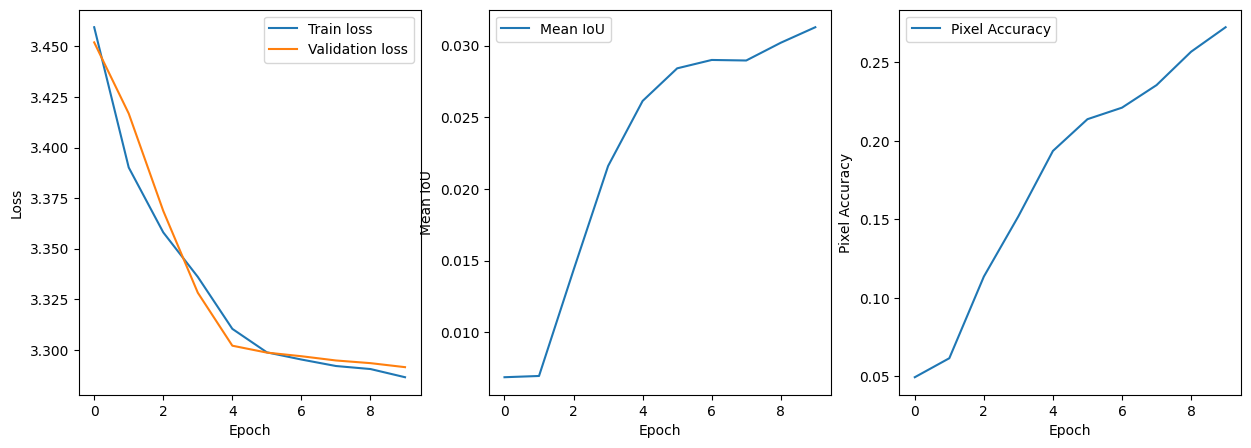

Best Mean IoU: 0.0313
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: SGD | Batch size: 32
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 3/3 [00:12<00:00,  4.11s/it]


Epoch 1/10
Train loss: 3.4053 | Validation loss: 3.4499
Mean IoU: 0.0016 | Pixel accuracy: 0.0093


100%|██████████| 3/3 [00:12<00:00,  4.31s/it]


Epoch 2/10
Train loss: 3.3429 | Validation loss: 3.4270
Mean IoU: 0.0040 | Pixel accuracy: 0.0415


100%|██████████| 3/3 [00:13<00:00,  4.45s/it]


Epoch 3/10
Train loss: 3.3063 | Validation loss: 3.3989
Mean IoU: 0.0089 | Pixel accuracy: 0.1008


100%|██████████| 3/3 [00:13<00:00,  4.41s/it]


Epoch 4/10
Train loss: 3.2797 | Validation loss: 3.3688
Mean IoU: 0.0154 | Pixel accuracy: 0.1663


100%|██████████| 3/3 [00:13<00:00,  4.55s/it]


Epoch 5/10
Train loss: 3.2570 | Validation loss: 3.3330
Mean IoU: 0.0223 | Pixel accuracy: 0.2349


100%|██████████| 3/3 [00:14<00:00,  4.67s/it]


Epoch 6/10
Train loss: 3.2451 | Validation loss: 3.3055
Mean IoU: 0.0264 | Pixel accuracy: 0.2876


100%|██████████| 3/3 [00:13<00:00,  4.65s/it]


Epoch 7/10
Train loss: 3.2422 | Validation loss: 3.2861
Mean IoU: 0.0294 | Pixel accuracy: 0.3392


100%|██████████| 3/3 [00:13<00:00,  4.53s/it]


Epoch 8/10
Train loss: 3.2414 | Validation loss: 3.2722
Mean IoU: 0.0312 | Pixel accuracy: 0.3780


100%|██████████| 3/3 [00:13<00:00,  4.60s/it]


Epoch 9/10
Train loss: 3.2398 | Validation loss: 3.2626
Mean IoU: 0.0325 | Pixel accuracy: 0.4019


100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


Epoch 10/10
Train loss: 3.2366 | Validation loss: 3.2553
Mean IoU: 0.0333 | Pixel accuracy: 0.4166
Training time: 160.09 seconds


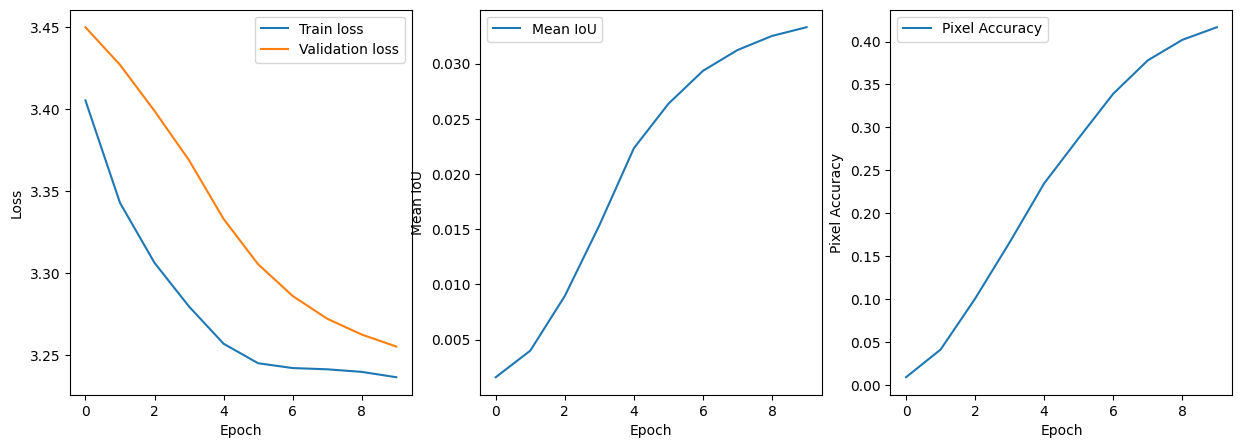

Best Mean IoU: 0.0333

Best batch_size: 32 | Mean IoU: 0.033305441029363926

Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: SGD | Batch size: 32
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 3/3 [00:11<00:00,  3.96s/it]


Epoch 1/10
Train loss: 3.4467 | Validation loss: 3.5069
Mean IoU: 0.0010 | Pixel accuracy: 0.0070


100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


Epoch 2/10
Train loss: 3.3915 | Validation loss: 3.4865
Mean IoU: 0.0021 | Pixel accuracy: 0.0126


100%|██████████| 3/3 [00:12<00:00,  4.26s/it]


Epoch 3/10
Train loss: 3.3554 | Validation loss: 3.4470
Mean IoU: 0.0036 | Pixel accuracy: 0.0292


100%|██████████| 3/3 [00:13<00:00,  4.34s/it]


Epoch 4/10
Train loss: 3.3311 | Validation loss: 3.4031
Mean IoU: 0.0164 | Pixel accuracy: 0.1390


100%|██████████| 3/3 [00:12<00:00,  4.30s/it]


Epoch 5/10
Train loss: 3.3117 | Validation loss: 3.3686
Mean IoU: 0.0329 | Pixel accuracy: 0.2858


100%|██████████| 3/3 [00:13<00:00,  4.38s/it]


Epoch 6/10
Train loss: 3.3005 | Validation loss: 3.3525
Mean IoU: 0.0357 | Pixel accuracy: 0.3131


100%|██████████| 3/3 [00:13<00:00,  4.44s/it]


Epoch 7/10
Train loss: 3.2988 | Validation loss: 3.3395
Mean IoU: 0.0377 | Pixel accuracy: 0.3325


100%|██████████| 3/3 [00:13<00:00,  4.58s/it]


Epoch 8/10
Train loss: 3.2973 | Validation loss: 3.3288
Mean IoU: 0.0395 | Pixel accuracy: 0.3479


100%|██████████| 3/3 [00:13<00:00,  4.51s/it]


Epoch 9/10
Train loss: 3.2948 | Validation loss: 3.3199
Mean IoU: 0.0410 | Pixel accuracy: 0.3606


100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


Epoch 10/10
Train loss: 3.2934 | Validation loss: 3.3130
Mean IoU: 0.0421 | Pixel accuracy: 0.3711
Training time: 155.56 seconds


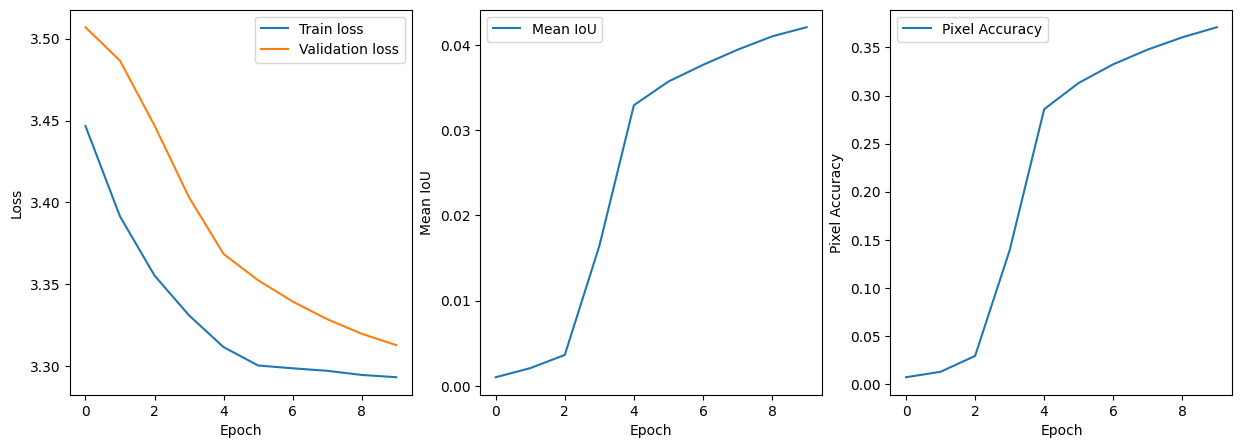

Best Mean IoU: 0.0421
Training and evaluating unet with the following hyperparameters:
  Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: SGD | Batch size: 32
  Scheduler: ExponentialLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.ExponentialLR'>, 'gamma': 0.95}



100%|██████████| 3/3 [00:13<00:00,  4.59s/it]


Epoch 1/10
Train loss: 3.4485 | Validation loss: 3.4608
Mean IoU: 0.0008 | Pixel accuracy: 0.0027


100%|██████████| 3/3 [00:12<00:00,  4.29s/it]


Epoch 2/10
Train loss: 3.3852 | Validation loss: 3.4346
Mean IoU: 0.0018 | Pixel accuracy: 0.0101


100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


Epoch 3/10
Train loss: 3.3539 | Validation loss: 3.3978
Mean IoU: 0.0035 | Pixel accuracy: 0.0343


100%|██████████| 3/3 [00:12<00:00,  4.14s/it]


Epoch 4/10
Train loss: 3.3309 | Validation loss: 3.3619
Mean IoU: 0.0058 | Pixel accuracy: 0.0700


100%|██████████| 3/3 [00:12<00:00,  4.29s/it]


Epoch 5/10
Train loss: 3.3132 | Validation loss: 3.3319
Mean IoU: 0.0111 | Pixel accuracy: 0.1371


100%|██████████| 3/3 [00:13<00:00,  4.41s/it]


Epoch 6/10
Train loss: 3.3010 | Validation loss: 3.3231
Mean IoU: 0.0148 | Pixel accuracy: 0.1809


100%|██████████| 3/3 [00:13<00:00,  4.40s/it]


Epoch 7/10
Train loss: 3.2994 | Validation loss: 3.3164
Mean IoU: 0.0179 | Pixel accuracy: 0.2129


100%|██████████| 3/3 [00:13<00:00,  4.55s/it]


Epoch 8/10
Train loss: 3.2981 | Validation loss: 3.3117
Mean IoU: 0.0201 | Pixel accuracy: 0.2346


100%|██████████| 3/3 [00:13<00:00,  4.55s/it]


Epoch 9/10
Train loss: 3.2964 | Validation loss: 3.3080
Mean IoU: 0.0218 | Pixel accuracy: 0.2505


100%|██████████| 3/3 [00:13<00:00,  4.56s/it]


Epoch 10/10
Train loss: 3.2938 | Validation loss: 3.3050
Mean IoU: 0.0230 | Pixel accuracy: 0.2622
Training time: 159.17 seconds


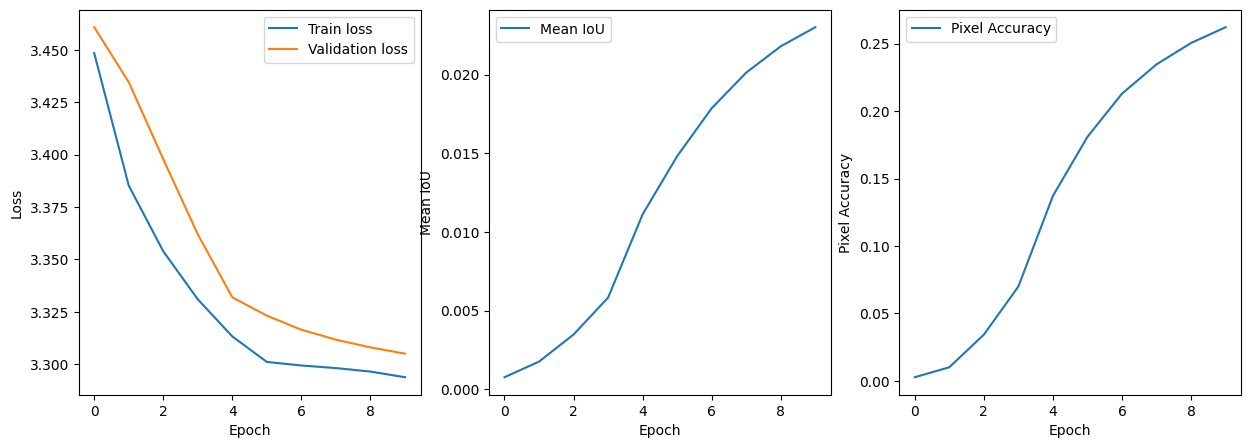

Best Mean IoU: 0.0230

Best scheduler: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1} | Mean IoU: 0.042097119063797955


Best performance for unet
Encoder: resnet101 | Weights: imagenet | Activation: sigmoid
Learning rate: 0.0001 | Optimizer: SGD | Batch size: 32
Scheduler: StepLR | Mean IoU: 0.042097119063797955


100%|██████████| 3/3 [00:13<00:00,  4.57s/it]


Epoch 1/10
Train loss: 3.3844 | Validation loss: 3.4497
Mean IoU: 0.0075 | Pixel accuracy: 0.0845


100%|██████████| 3/3 [00:13<00:00,  4.64s/it]


Epoch 2/10
Train loss: 3.3256 | Validation loss: 3.4310
Mean IoU: 0.0139 | Pixel accuracy: 0.1441


100%|██████████| 3/3 [00:13<00:00,  4.46s/it]


Epoch 3/10
Train loss: 3.2936 | Validation loss: 3.3879
Mean IoU: 0.0243 | Pixel accuracy: 0.2705


100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


Epoch 4/10
Train loss: 3.2684 | Validation loss: 3.3369
Mean IoU: 0.0336 | Pixel accuracy: 0.3877


100%|██████████| 3/3 [00:12<00:00,  4.10s/it]


Epoch 5/10
Train loss: 3.2482 | Validation loss: 3.2946
Mean IoU: 0.0471 | Pixel accuracy: 0.4841


100%|██████████| 3/3 [00:12<00:00,  4.24s/it]


Epoch 6/10
Train loss: 3.2349 | Validation loss: 3.2855
Mean IoU: 0.0498 | Pixel accuracy: 0.4845


100%|██████████| 3/3 [00:12<00:00,  4.33s/it]


Epoch 7/10
Train loss: 3.2331 | Validation loss: 3.2740
Mean IoU: 0.0541 | Pixel accuracy: 0.5027


100%|██████████| 3/3 [00:13<00:00,  4.41s/it]


Epoch 8/10
Train loss: 3.2302 | Validation loss: 3.2632
Mean IoU: 0.0587 | Pixel accuracy: 0.5277


100%|██████████| 3/3 [00:13<00:00,  4.52s/it]


Epoch 9/10
Train loss: 3.2280 | Validation loss: 3.2547
Mean IoU: 0.0616 | Pixel accuracy: 0.5452


100%|██████████| 3/3 [00:13<00:00,  4.62s/it]


Epoch 10/10
Train loss: 3.2258 | Validation loss: 3.2477
Mean IoU: 0.0635 | Pixel accuracy: 0.5593
Training time: 160.09 seconds


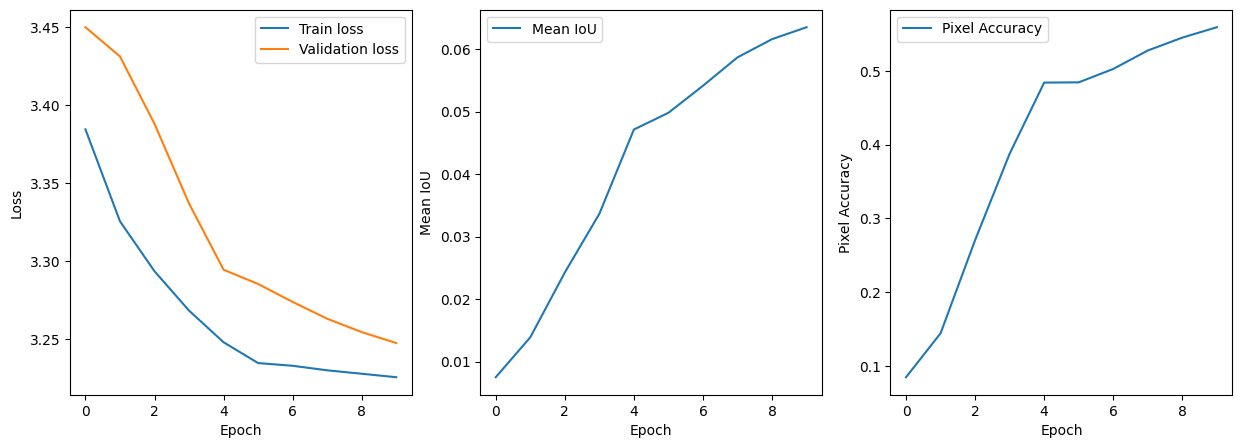

Best Mean IoU: 0.0635


In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 10

    model_info_list = [
        {"name": "unet", "model": smp.Unet}
    ]

    best_parameters_list = [] 

    for model_info in model_info_list:

        best_parameters = {
            "encoder_name": "resnet50",
            "encoder_weights": None,
            "activation": None,
            "learning_rate": 1e-4,
            "optimizer": optim.Adam,
            "batch_size": 16,
            "scheduler": {"scheduler": optim.lr_scheduler.StepLR, "step_size": 5, "gamma": 0.1},
            "mean_iou": 0
        }

        # Hyperparameters to explore
        encoder_names = ['resnet50', 'resnet101']
        encoder_weights = [None, 'imagenet']
        activation_functions = [None, 'sigmoid', 'softmax2d']
        learning_rates = [1e-4, 5e-5]
        optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
        batch_sizes = [16, 32]
        scheduler_options = [
            {"scheduler": optim.lr_scheduler.StepLR, "step_size": 5, "gamma": 0.1},
            {"scheduler": optim.lr_scheduler.ExponentialLR, "gamma": 0.95}
        ]

        hyperparameter_lists = [
            ("encoder_name", encoder_names),
            ("encoder_weights", encoder_weights),
            ("activation", activation_functions),
            ("learning_rate", learning_rates),
            ("optimizer", optimizers),
            ("batch_size", batch_sizes),
            ("scheduler", scheduler_options)
        ]

        for hyperparameter_name, hyperparameter_values in hyperparameter_lists:
            best_hyperparameter_value = None
            best_hyperparameter_iou = 0

            for hyperparameter_value in hyperparameter_values:
                current_parameters = best_parameters.copy()
                current_parameters[hyperparameter_name] = hyperparameter_value

                print(f"Training and evaluating {model_info['name']} with the following hyperparameters:")
                print(f"  Encoder: {current_parameters['encoder_name']} | Weights: {current_parameters['encoder_weights']} | Activation: {current_parameters['activation']}")
                print(f"  Learning rate: {current_parameters['learning_rate']} | Optimizer: {current_parameters['optimizer'].__name__} | Batch size: {current_parameters['batch_size']}")
                print(f"  Scheduler: {current_parameters['scheduler']['scheduler'].__name__} | Params: {current_parameters['scheduler']}\n")

                model = model_info["model"](encoder_name=current_parameters["encoder_name"],
                                             encoder_weights=current_parameters["encoder_weights"],
                                             classes=32,
                                             activation=current_parameters["activation"]).to(device)

                train_loader = DataLoader(train_dataset, batch_size=current_parameters["batch_size"], shuffle=True, num_workers=2)
                val_loader = DataLoader(val_dataset, batch_size=current_parameters["batch_size"], shuffle=False, num_workers=2)

                mean_iou = train_and_evaluate(model, train_loader, val_loader, epochs,
                                              current_parameters["learning_rate"],
                                              current_parameters["optimizer"],
                                              device, model_info["name"],
                                              current_parameters["scheduler"])

                if mean_iou > best_hyperparameter_iou:
                    best_hyperparameter_iou = mean_iou
                    best_hyperparameter_value = hyperparameter_value

            best_parameters[hyperparameter_name] = best_hyperparameter_value
            best_parameters["mean_iou"] = best_hyperparameter_iou
            print(f"\nBest {hyperparameter_name}: {best_hyperparameter_value} | Mean IoU: {best_hyperparameter_iou}\n")

        print("\nBest performance for", model_info["name"])
        print(f"Encoder: {best_parameters['encoder_name']} | Weights: {best_parameters['encoder_weights']} | Activation: {best_parameters['activation']}")
        print(f"Learning rate: {best_parameters['learning_rate']} | Optimizer: {best_parameters['optimizer'].__name__} | Batch size: {best_parameters['batch_size']}")
        print(f"Scheduler: {best_parameters['scheduler']['scheduler'].__name__} | Mean IoU: {best_parameters['mean_iou']}")

        # Train the model with the best hyperparameters
        model = model_info["model"](encoder_name=best_parameters["encoder_name"],
                                     encoder_weights=best_parameters["encoder_weights"],
                                     classes=32,
                                     activation=best_parameters["activation"]).to(device)

        train_loader = DataLoader(train_dataset, batch_size=best_parameters["batch_size"], shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=best_parameters["batch_size"], shuffle=False, num_workers=2)

        train_and_evaluate(model, train_loader, val_loader, epochs,
                           best_parameters["learning_rate"],
                           best_parameters["optimizer"],
                           device, model_info["name"],
                           best_parameters["scheduler"])

        # Save the model state dict
        torch.save(model.state_dict(), f"best_model_{model_info['name']}.pth")

        # Add the best parameters for the model to the list
        best_parameters["name"] = model_info["name"]
        best_parameters_list.append(best_parameters.copy())

    # Return the list of best parameters
    return best_parameters_list


if __name__ == "__main__":
    best_parameters_list_unet = main()

    with open('best_parameters_list_unet.pkl', 'wb') as f:
        pickle.dump(best_parameters_list_unet, f)

> 5.2.

*   Train and Evaluate FPN model
*   Explore best hyperparameters



Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 1/10
Train loss: 6.0415 | Validation loss: 3.9963
Mean IoU: 0.0017 | Pixel accuracy: 0.0177


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 2/10
Train loss: 1.9580 | Validation loss: 2.1765
Mean IoU: 0.0184 | Pixel accuracy: 0.5809


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 3/10
Train loss: 1.3021 | Validation loss: 1.9080
Mean IoU: 0.0258 | Pixel accuracy: 0.5346


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 4/10
Train loss: 1.1154 | Validation loss: 1.3115
Mean IoU: 0.0488 | Pixel accuracy: 0.7176


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 5/10
Train loss: 1.0380 | Validation loss: 1.3562
Mean IoU: 0.0598 | Pixel accuracy: 0.7413


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 6/10
Train loss: 0.9304 | Validation loss: 1.2232
Mean IoU: 0.0621 | Pixel accuracy: 0.7618


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 7/10
Train loss: 0.8681 | Validation loss: 0.9869
Mean IoU: 0.0640 | Pixel accuracy: 0.7827


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 8/10
Train loss: 0.8452 | Validation loss: 0.8503
Mean IoU: 0.0651 | Pixel accuracy: 0.7939


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 9/10
Train loss: 0.8108 | Validation loss: 0.7689
Mean IoU: 0.0661 | Pixel accuracy: 0.7999


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 10/10
Train loss: 0.7921 | Validation loss: 0.7333
Mean IoU: 0.0672 | Pixel accuracy: 0.8107
Training time: 156.15 seconds


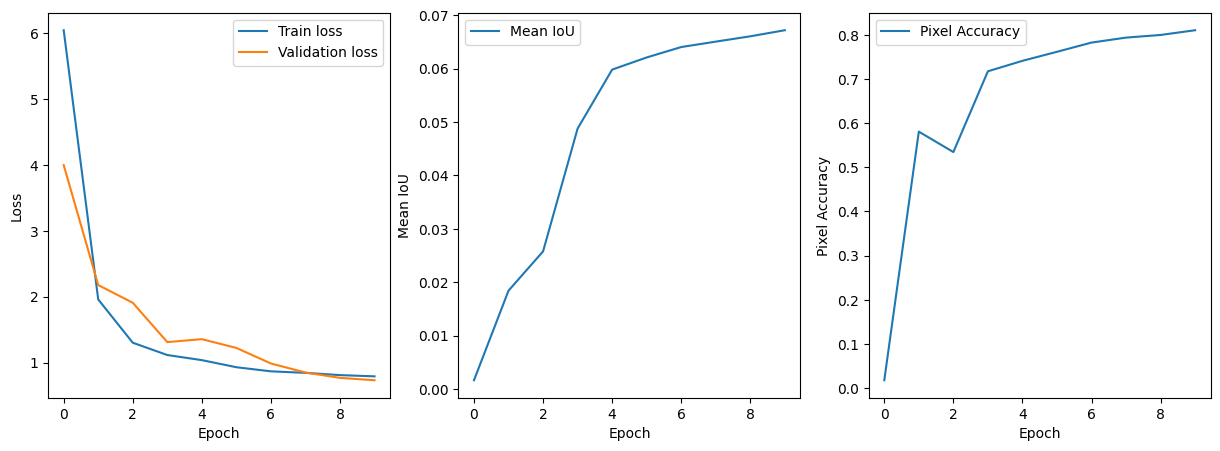

Best Mean IoU: 0.0672
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet101 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:11<00:00,  1.96s/it]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/10
Train loss: 6.0549 | Validation loss: 5.6461
Mean IoU: 0.0007 | Pixel accuracy: 0.0040


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 2/10
Train loss: 2.7723 | Validation loss: 2.0532
Mean IoU: 0.0184 | Pixel accuracy: 0.5719


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch 3/10
Train loss: 1.4213 | Validation loss: 1.8548
Mean IoU: 0.0267 | Pixel accuracy: 0.5742


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 4/10
Train loss: 1.1965 | Validation loss: 1.5896
Mean IoU: 0.0306 | Pixel accuracy: 0.6197


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 5/10
Train loss: 1.2286 | Validation loss: 1.3210
Mean IoU: 0.0434 | Pixel accuracy: 0.6697


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 6/10
Train loss: 0.9926 | Validation loss: 1.0571
Mean IoU: 0.0583 | Pixel accuracy: 0.7480


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 7/10
Train loss: 0.9924 | Validation loss: 0.9476
Mean IoU: 0.0604 | Pixel accuracy: 0.7606


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 8/10
Train loss: 1.0269 | Validation loss: 0.8648
Mean IoU: 0.0603 | Pixel accuracy: 0.7674


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 9/10
Train loss: 0.9654 | Validation loss: 0.8174
Mean IoU: 0.0623 | Pixel accuracy: 0.7874


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 10/10
Train loss: 1.0061 | Validation loss: 0.8033
Mean IoU: 0.0627 | Pixel accuracy: 0.7828
Training time: 157.42 seconds


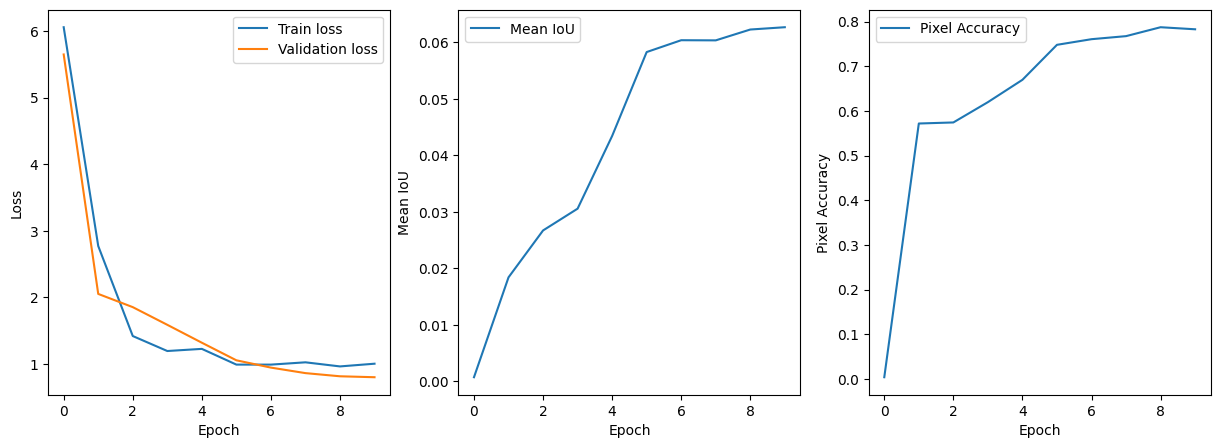

Best Mean IoU: 0.0627

Best encoder_name: resnet50 | Mean IoU: 0.0671924340835115

Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 1/10
Train loss: 6.4373 | Validation loss: 4.0223
Mean IoU: 0.0084 | Pixel accuracy: 0.2109


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 2/10
Train loss: 2.4365 | Validation loss: 2.0563
Mean IoU: 0.0247 | Pixel accuracy: 0.5713


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 3/10
Train loss: 1.4007 | Validation loss: 2.0446
Mean IoU: 0.0165 | Pixel accuracy: 0.3842


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch 4/10
Train loss: 1.0964 | Validation loss: 1.3706
Mean IoU: 0.0430 | Pixel accuracy: 0.5854


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 5/10
Train loss: 0.9892 | Validation loss: 1.2065
Mean IoU: 0.0555 | Pixel accuracy: 0.6777


100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch 6/10
Train loss: 0.8956 | Validation loss: 0.9384
Mean IoU: 0.0629 | Pixel accuracy: 0.7667


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


Epoch 7/10
Train loss: 0.8769 | Validation loss: 0.8152
Mean IoU: 0.0661 | Pixel accuracy: 0.7975


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


Epoch 8/10
Train loss: 0.8417 | Validation loss: 0.7488
Mean IoU: 0.0677 | Pixel accuracy: 0.8149


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 9/10
Train loss: 0.7719 | Validation loss: 0.7062
Mean IoU: 0.0696 | Pixel accuracy: 0.8280


100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch 10/10
Train loss: 0.7935 | Validation loss: 0.7052
Mean IoU: 0.0683 | Pixel accuracy: 0.8195
Training time: 152.07 seconds


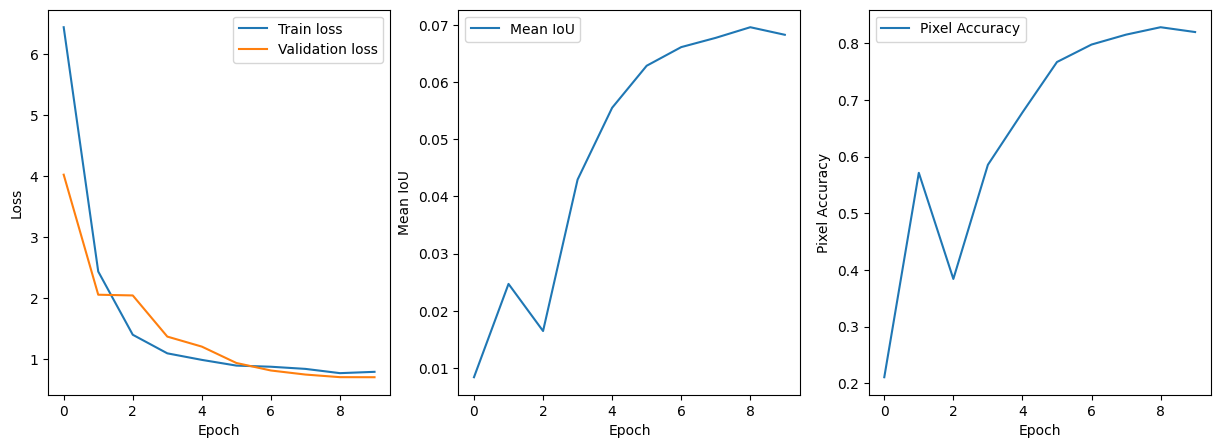

Best Mean IoU: 0.0696
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 44.6MB/s]
100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 1/10
Train loss: 3.8413 | Validation loss: 0.9860
Mean IoU: 0.0689 | Pixel accuracy: 0.8242


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 2/10
Train loss: 0.7932 | Validation loss: 0.5995
Mean IoU: 0.0746 | Pixel accuracy: 0.8560


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 3/10
Train loss: 0.6132 | Validation loss: 0.5180
Mean IoU: 0.0835 | Pixel accuracy: 0.8641


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 4/10
Train loss: 0.4914 | Validation loss: 0.4817
Mean IoU: 0.0828 | Pixel accuracy: 0.8680


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 5/10
Train loss: 0.4456 | Validation loss: 0.4220
Mean IoU: 0.0827 | Pixel accuracy: 0.8796


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 6/10
Train loss: 0.4338 | Validation loss: 0.4117
Mean IoU: 0.0834 | Pixel accuracy: 0.8812


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 7/10
Train loss: 0.4682 | Validation loss: 0.4063
Mean IoU: 0.0847 | Pixel accuracy: 0.8827


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 8/10
Train loss: 0.4027 | Validation loss: 0.3985
Mean IoU: 0.0866 | Pixel accuracy: 0.8848


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 9/10
Train loss: 0.4081 | Validation loss: 0.3963
Mean IoU: 0.0869 | Pixel accuracy: 0.8838


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 10/10
Train loss: 0.4039 | Validation loss: 0.3938
Mean IoU: 0.0884 | Pixel accuracy: 0.8857
Training time: 155.97 seconds


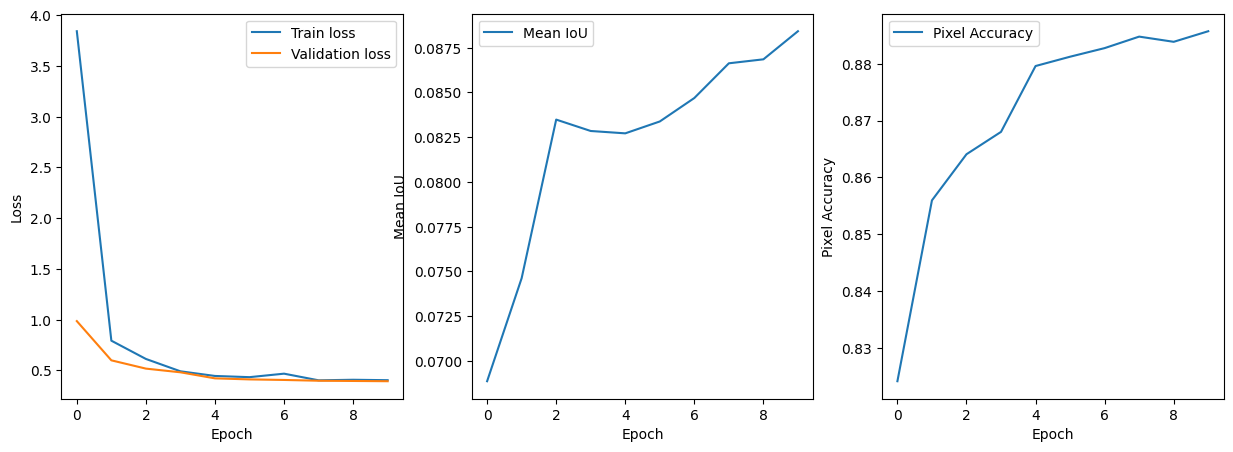

Best Mean IoU: 0.0884

Best encoder_weights: imagenet | Mean IoU: 0.08842463350665282

Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


Epoch 1/10
Train loss: 3.9743 | Validation loss: 1.0802
Mean IoU: 0.0667 | Pixel accuracy: 0.8181


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 2/10
Train loss: 0.9335 | Validation loss: 0.6965
Mean IoU: 0.0748 | Pixel accuracy: 0.8599


100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch 3/10
Train loss: 0.6423 | Validation loss: 0.5497
Mean IoU: 0.0821 | Pixel accuracy: 0.8661


100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Epoch 4/10
Train loss: 0.5307 | Validation loss: 0.4906
Mean IoU: 0.0866 | Pixel accuracy: 0.8771


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 5/10
Train loss: 0.4640 | Validation loss: 0.4432
Mean IoU: 0.0883 | Pixel accuracy: 0.8856


100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch 6/10
Train loss: 0.4469 | Validation loss: 0.4324
Mean IoU: 0.0885 | Pixel accuracy: 0.8875


100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch 7/10
Train loss: 0.4338 | Validation loss: 0.4221
Mean IoU: 0.0890 | Pixel accuracy: 0.8888


100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


Epoch 8/10
Train loss: 0.3990 | Validation loss: 0.4155
Mean IoU: 0.0894 | Pixel accuracy: 0.8891


100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Epoch 9/10
Train loss: 0.4129 | Validation loss: 0.4123
Mean IoU: 0.0897 | Pixel accuracy: 0.8884


100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch 10/10
Train loss: 0.4076 | Validation loss: 0.4085
Mean IoU: 0.0898 | Pixel accuracy: 0.8887
Training time: 149.80 seconds


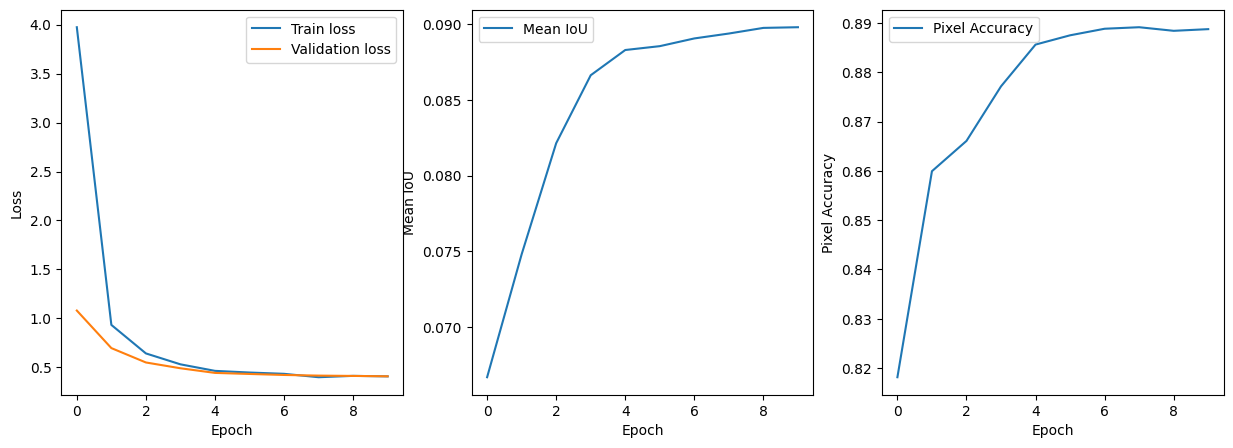

Best Mean IoU: 0.0898
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 1/10
Train loss: 3.1948 | Validation loss: 2.9408
Mean IoU: 0.0593 | Pixel accuracy: 0.7818


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 2/10
Train loss: 2.8958 | Validation loss: 2.8061
Mean IoU: 0.0669 | Pixel accuracy: 0.8144


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 3/10
Train loss: 2.7978 | Validation loss: 2.7223
Mean IoU: 0.0697 | Pixel accuracy: 0.8031


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch 4/10
Train loss: 2.7277 | Validation loss: 2.6836
Mean IoU: 0.0711 | Pixel accuracy: 0.8146


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 5/10
Train loss: 2.7097 | Validation loss: 2.6668
Mean IoU: 0.0730 | Pixel accuracy: 0.8240


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 6/10
Train loss: 2.7044 | Validation loss: 2.6646
Mean IoU: 0.0728 | Pixel accuracy: 0.8272


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch 7/10
Train loss: 2.6987 | Validation loss: 2.6631
Mean IoU: 0.0719 | Pixel accuracy: 0.8233


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 8/10
Train loss: 2.6997 | Validation loss: 2.6617
Mean IoU: 0.0721 | Pixel accuracy: 0.8243


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 9/10
Train loss: 2.6930 | Validation loss: 2.6602
Mean IoU: 0.0725 | Pixel accuracy: 0.8269


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 10/10
Train loss: 2.6906 | Validation loss: 2.6586
Mean IoU: 0.0727 | Pixel accuracy: 0.8278
Training time: 147.42 seconds


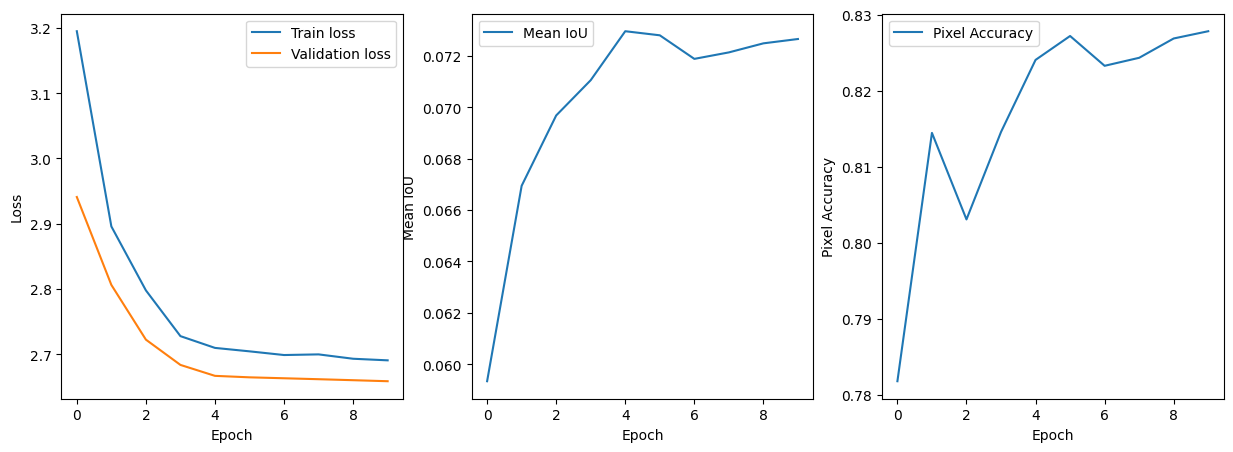

Best Mean IoU: 0.0730
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: softmax2d
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 1/10
Train loss: 3.2301 | Validation loss: 3.1483
Mean IoU: 0.0212 | Pixel accuracy: 0.3509


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 2/10
Train loss: 2.9431 | Validation loss: 2.7142
Mean IoU: 0.0679 | Pixel accuracy: 0.8154


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 3/10
Train loss: 2.6878 | Validation loss: 2.6593
Mean IoU: 0.0751 | Pixel accuracy: 0.8620


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 4/10
Train loss: 2.6639 | Validation loss: 2.6460
Mean IoU: 0.0775 | Pixel accuracy: 0.8741


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 5/10
Train loss: 2.6446 | Validation loss: 2.6435
Mean IoU: 0.0780 | Pixel accuracy: 0.8761


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 6/10
Train loss: 2.6370 | Validation loss: 2.6427
Mean IoU: 0.0785 | Pixel accuracy: 0.8769


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 7/10
Train loss: 2.6353 | Validation loss: 2.6425
Mean IoU: 0.0786 | Pixel accuracy: 0.8766


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 8/10
Train loss: 2.6362 | Validation loss: 2.6416
Mean IoU: 0.0788 | Pixel accuracy: 0.8775


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 9/10
Train loss: 2.6407 | Validation loss: 2.6417
Mean IoU: 0.0789 | Pixel accuracy: 0.8776


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 10/10
Train loss: 2.6368 | Validation loss: 2.6410
Mean IoU: 0.0789 | Pixel accuracy: 0.8782
Training time: 153.37 seconds


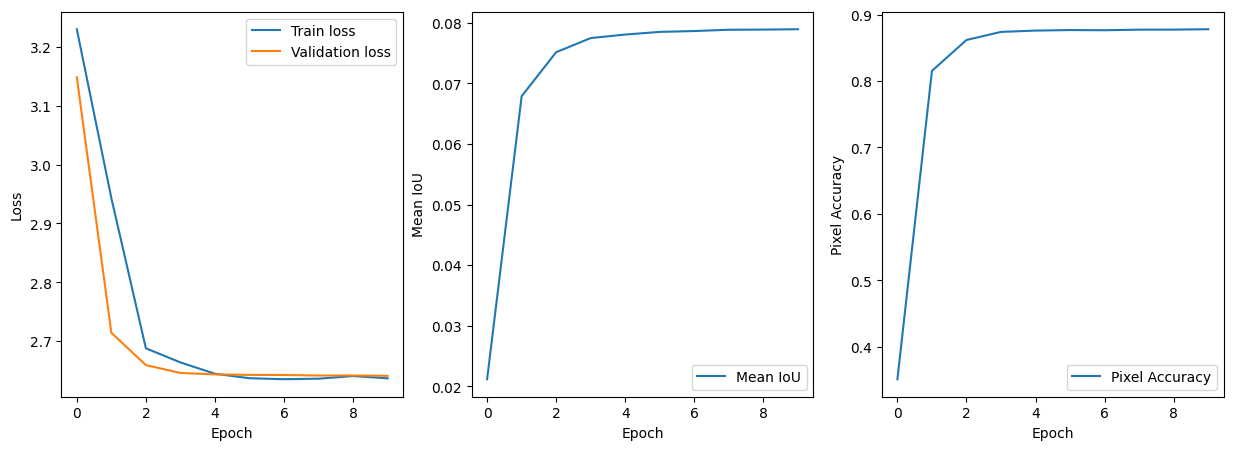

Best Mean IoU: 0.0789

Best activation: None | Mean IoU: 0.08978553079880687

Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 1/10
Train loss: 3.7128 | Validation loss: 1.0090
Mean IoU: 0.0609 | Pixel accuracy: 0.7955


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 2/10
Train loss: 0.8556 | Validation loss: 0.6333
Mean IoU: 0.0785 | Pixel accuracy: 0.8529


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 3/10
Train loss: 0.5901 | Validation loss: 0.5232
Mean IoU: 0.0833 | Pixel accuracy: 0.8635


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 4/10
Train loss: 0.5382 | Validation loss: 0.4762
Mean IoU: 0.0805 | Pixel accuracy: 0.8716


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 5/10
Train loss: 0.4989 | Validation loss: 0.4430
Mean IoU: 0.0841 | Pixel accuracy: 0.8720


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 6/10
Train loss: 0.4071 | Validation loss: 0.4289
Mean IoU: 0.0871 | Pixel accuracy: 0.8770


100%|██████████| 6/6 [00:11<00:00,  1.97s/it]


Epoch 7/10
Train loss: 0.4379 | Validation loss: 0.4151
Mean IoU: 0.0878 | Pixel accuracy: 0.8820


100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Epoch 8/10
Train loss: 0.4026 | Validation loss: 0.4069
Mean IoU: 0.0886 | Pixel accuracy: 0.8848


100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Epoch 9/10
Train loss: 0.3873 | Validation loss: 0.4031
Mean IoU: 0.0889 | Pixel accuracy: 0.8852


100%|██████████| 6/6 [00:11<00:00,  1.93s/it]


Epoch 10/10
Train loss: 0.4165 | Validation loss: 0.3997
Mean IoU: 0.0907 | Pixel accuracy: 0.8864
Training time: 152.02 seconds


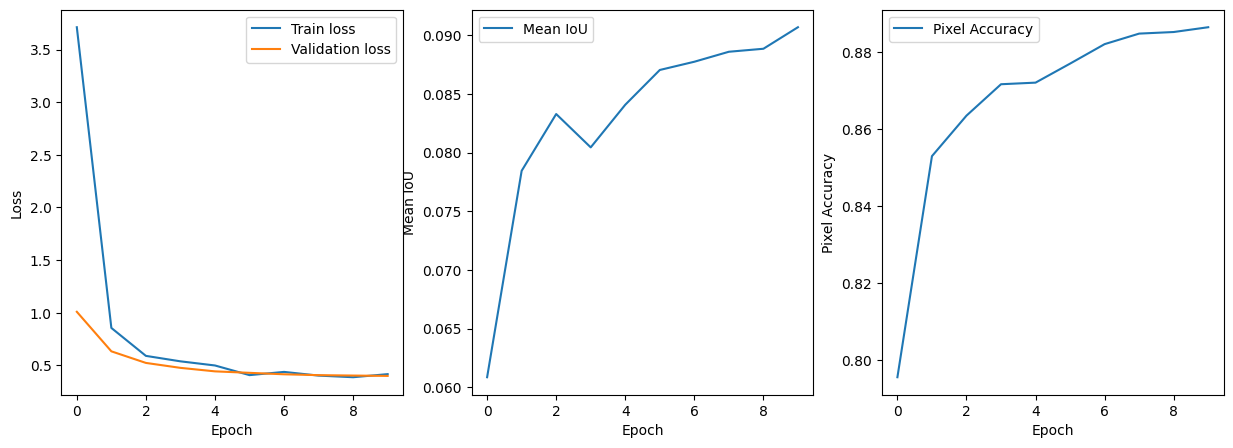

Best Mean IoU: 0.0907
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 5e-05 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 1/10
Train loss: 4.3613 | Validation loss: 1.9355
Mean IoU: 0.0420 | Pixel accuracy: 0.5215


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 2/10
Train loss: 1.3445 | Validation loss: 0.9055
Mean IoU: 0.0720 | Pixel accuracy: 0.8392


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 3/10
Train loss: 0.8239 | Validation loss: 0.7552
Mean IoU: 0.0731 | Pixel accuracy: 0.8460


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 4/10
Train loss: 0.6777 | Validation loss: 0.6174
Mean IoU: 0.0786 | Pixel accuracy: 0.8651


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch 5/10
Train loss: 0.5768 | Validation loss: 0.5776
Mean IoU: 0.0822 | Pixel accuracy: 0.8603


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 6/10
Train loss: 0.6229 | Validation loss: 0.5706
Mean IoU: 0.0827 | Pixel accuracy: 0.8619


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 7/10
Train loss: 0.5658 | Validation loss: 0.5576
Mean IoU: 0.0834 | Pixel accuracy: 0.8641


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 8/10
Train loss: 0.5337 | Validation loss: 0.5452
Mean IoU: 0.0839 | Pixel accuracy: 0.8671


100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch 9/10
Train loss: 0.5674 | Validation loss: 0.5434
Mean IoU: 0.0837 | Pixel accuracy: 0.8694


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 10/10
Train loss: 0.5179 | Validation loss: 0.5377
Mean IoU: 0.0840 | Pixel accuracy: 0.8709
Training time: 147.72 seconds


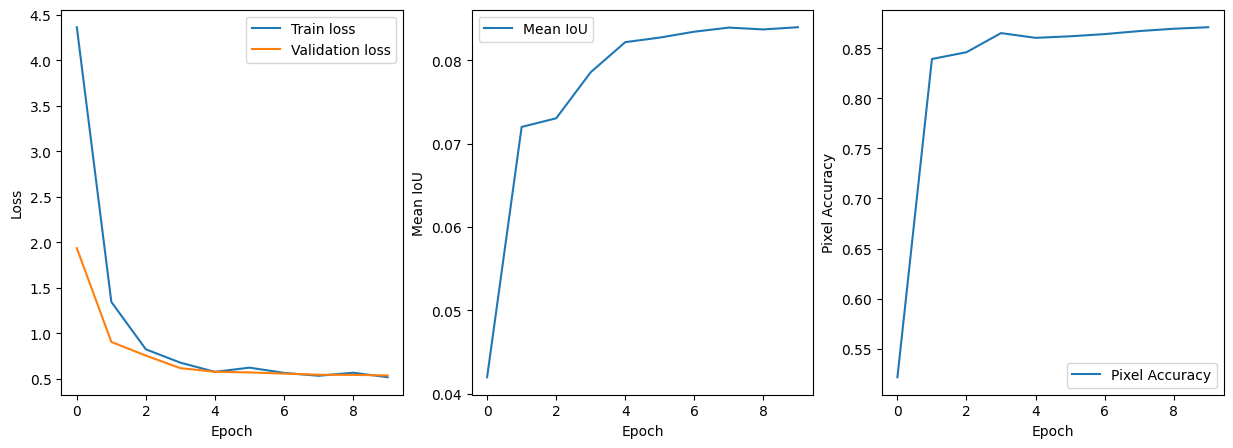

Best Mean IoU: 0.0840

Best learning_rate: 0.0001 | Mean IoU: 0.09070005470180934

Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 1/10
Train loss: 3.2418 | Validation loss: 0.9148
Mean IoU: 0.0598 | Pixel accuracy: 0.8068


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 2/10
Train loss: 0.7521 | Validation loss: 0.6050
Mean IoU: 0.0799 | Pixel accuracy: 0.8560


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 3/10
Train loss: 0.5772 | Validation loss: 0.4874
Mean IoU: 0.0810 | Pixel accuracy: 0.8668


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 4/10
Train loss: 0.4720 | Validation loss: 0.4259
Mean IoU: 0.0879 | Pixel accuracy: 0.8778


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 5/10
Train loss: 0.4196 | Validation loss: 0.4073
Mean IoU: 0.0909 | Pixel accuracy: 0.8810


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 6/10
Train loss: 0.3979 | Validation loss: 0.4007
Mean IoU: 0.0912 | Pixel accuracy: 0.8815


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 7/10
Train loss: 0.3836 | Validation loss: 0.3914
Mean IoU: 0.0925 | Pixel accuracy: 0.8832


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 8/10
Train loss: 0.3716 | Validation loss: 0.3821
Mean IoU: 0.0941 | Pixel accuracy: 0.8854


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 9/10
Train loss: 0.3854 | Validation loss: 0.3781
Mean IoU: 0.0955 | Pixel accuracy: 0.8862


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 10/10
Train loss: 0.3904 | Validation loss: 0.3762
Mean IoU: 0.0967 | Pixel accuracy: 0.8867
Training time: 155.81 seconds


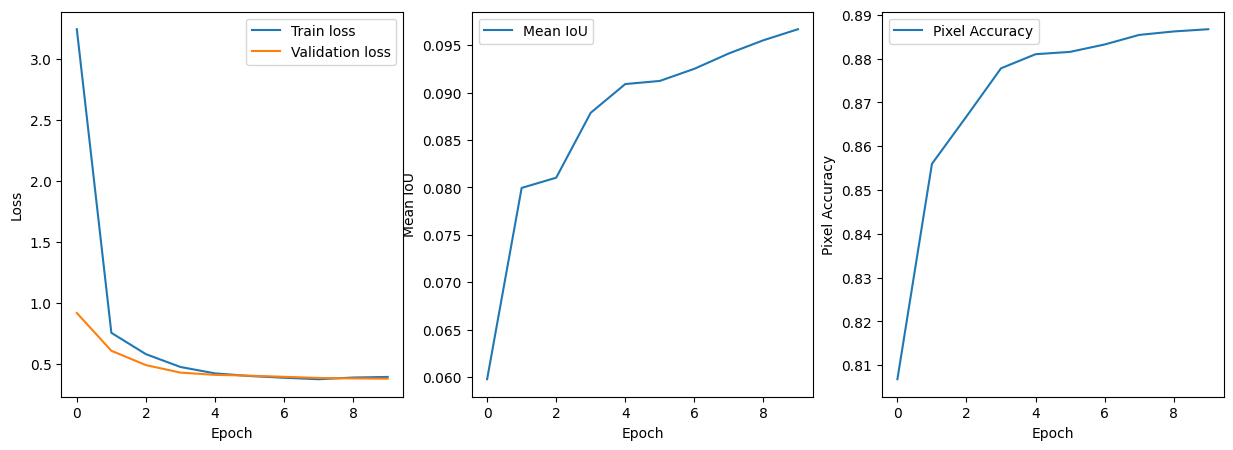

Best Mean IoU: 0.0967
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: SGD | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 1/10
Train loss: 4.7056 | Validation loss: 0.9924
Mean IoU: 0.0690 | Pixel accuracy: 0.8241


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 2/10
Train loss: 0.9247 | Validation loss: 0.6245
Mean IoU: 0.0750 | Pixel accuracy: 0.8577


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 3/10
Train loss: 0.6379 | Validation loss: 0.5290
Mean IoU: 0.0809 | Pixel accuracy: 0.8678


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch 4/10
Train loss: 0.5594 | Validation loss: 0.4756
Mean IoU: 0.0771 | Pixel accuracy: 0.8708


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 5/10
Train loss: 0.4886 | Validation loss: 0.4320
Mean IoU: 0.0852 | Pixel accuracy: 0.8811


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 6/10
Train loss: 0.4321 | Validation loss: 0.4165
Mean IoU: 0.0870 | Pixel accuracy: 0.8835


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 7/10
Train loss: 0.4413 | Validation loss: 0.4115
Mean IoU: 0.0868 | Pixel accuracy: 0.8844


100%|██████████| 6/6 [00:11<00:00,  1.96s/it]


Epoch 8/10
Train loss: 0.4346 | Validation loss: 0.4090
Mean IoU: 0.0868 | Pixel accuracy: 0.8841


100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch 9/10
Train loss: 0.4764 | Validation loss: 0.4014
Mean IoU: 0.0876 | Pixel accuracy: 0.8846


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 10/10
Train loss: 0.4050 | Validation loss: 0.4004
Mean IoU: 0.0872 | Pixel accuracy: 0.8852
Training time: 153.07 seconds


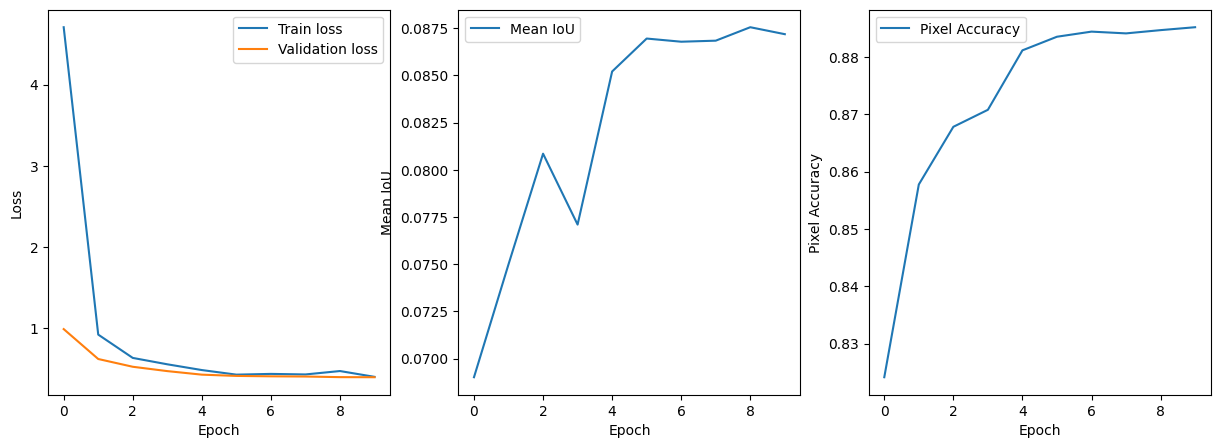

Best Mean IoU: 0.0876
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: RMSprop | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 1/10
Train loss: 2.7273 | Validation loss: 0.8360
Mean IoU: 0.0681 | Pixel accuracy: 0.8301


100%|██████████| 6/6 [00:12<00:00,  2.17s/it]


Epoch 2/10
Train loss: 0.7206 | Validation loss: 0.5807
Mean IoU: 0.0837 | Pixel accuracy: 0.8548


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 3/10
Train loss: 0.5720 | Validation loss: 0.4688
Mean IoU: 0.0778 | Pixel accuracy: 0.8683


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 4/10
Train loss: 0.5467 | Validation loss: 0.4263
Mean IoU: 0.0801 | Pixel accuracy: 0.8745


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 5/10
Train loss: 0.4487 | Validation loss: 0.3837
Mean IoU: 0.0925 | Pixel accuracy: 0.8786


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 6/10
Train loss: 0.3751 | Validation loss: 0.3814
Mean IoU: 0.0923 | Pixel accuracy: 0.8777


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 7/10
Train loss: 0.3738 | Validation loss: 0.3810
Mean IoU: 0.0913 | Pixel accuracy: 0.8792


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 8/10
Train loss: 0.3616 | Validation loss: 0.3811
Mean IoU: 0.0901 | Pixel accuracy: 0.8813


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 9/10
Train loss: 0.3713 | Validation loss: 0.3816
Mean IoU: 0.0899 | Pixel accuracy: 0.8827


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 10/10
Train loss: 0.3627 | Validation loss: 0.3786
Mean IoU: 0.0897 | Pixel accuracy: 0.8840
Training time: 153.99 seconds


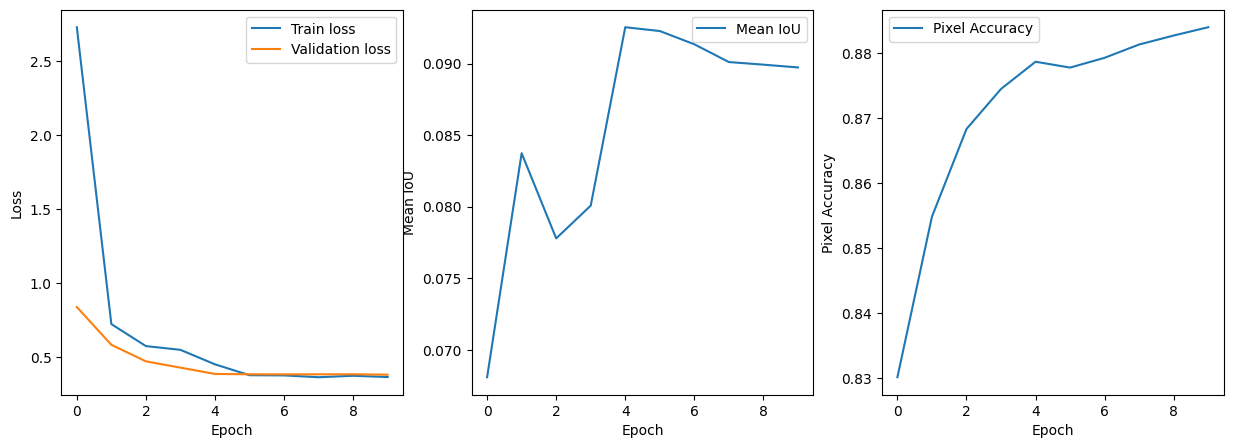

Best Mean IoU: 0.0925

Best optimizer: <class 'torch.optim.adam.Adam'> | Mean IoU: 0.09668319615340654

Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 1/10
Train loss: 2.5299 | Validation loss: 0.7543
Mean IoU: 0.0698 | Pixel accuracy: 0.8235


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch 2/10
Train loss: 0.6920 | Validation loss: 0.5688
Mean IoU: 0.0813 | Pixel accuracy: 0.8562


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 3/10
Train loss: 0.5383 | Validation loss: 0.5163
Mean IoU: 0.0861 | Pixel accuracy: 0.8627


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 4/10
Train loss: 0.4462 | Validation loss: 0.4495
Mean IoU: 0.0854 | Pixel accuracy: 0.8758


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 5/10
Train loss: 0.4146 | Validation loss: 0.4091
Mean IoU: 0.0904 | Pixel accuracy: 0.8835


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 6/10
Train loss: 0.4265 | Validation loss: 0.3994
Mean IoU: 0.0912 | Pixel accuracy: 0.8863


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 7/10
Train loss: 0.3830 | Validation loss: 0.3942
Mean IoU: 0.0918 | Pixel accuracy: 0.8871


100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch 8/10
Train loss: 0.3852 | Validation loss: 0.3893
Mean IoU: 0.0914 | Pixel accuracy: 0.8892


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 9/10
Train loss: 0.3646 | Validation loss: 0.3851
Mean IoU: 0.0918 | Pixel accuracy: 0.8891


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 10/10
Train loss: 0.3479 | Validation loss: 0.3819
Mean IoU: 0.0912 | Pixel accuracy: 0.8887
Training time: 155.54 seconds


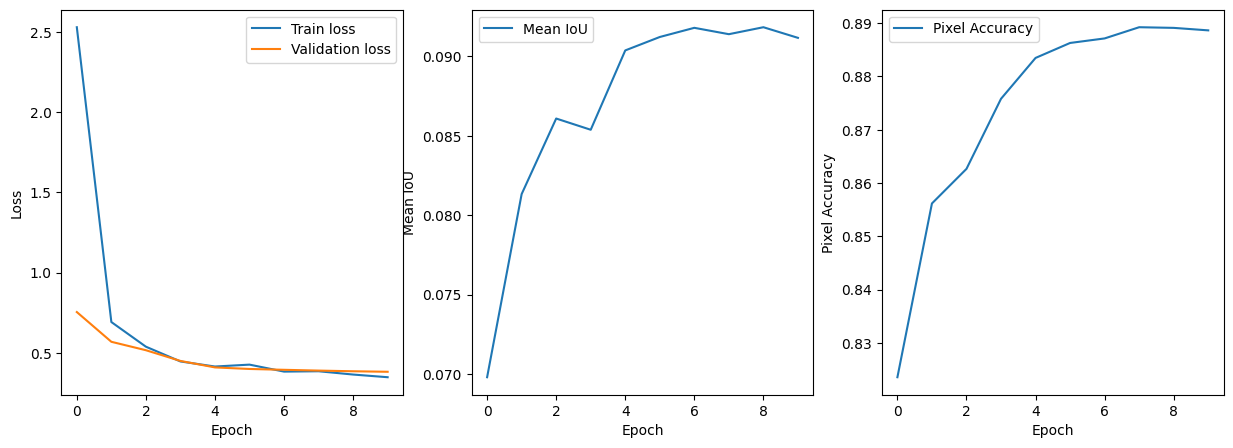

Best Mean IoU: 0.0918
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 32
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 3/3 [00:12<00:00,  4.30s/it]


Epoch 1/10
Train loss: 7.7690 | Validation loss: 5.4829
Mean IoU: 0.0003 | Pixel accuracy: 0.0033


100%|██████████| 3/3 [00:13<00:00,  4.34s/it]


Epoch 2/10
Train loss: 3.6949 | Validation loss: 1.3225
Mean IoU: 0.0647 | Pixel accuracy: 0.7651


100%|██████████| 3/3 [00:13<00:00,  4.51s/it]


Epoch 3/10
Train loss: 0.9913 | Validation loss: 0.7174
Mean IoU: 0.0771 | Pixel accuracy: 0.8530


100%|██████████| 3/3 [00:13<00:00,  4.49s/it]


Epoch 4/10
Train loss: 0.6981 | Validation loss: 0.6163
Mean IoU: 0.0819 | Pixel accuracy: 0.8553


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


Epoch 5/10
Train loss: 0.6194 | Validation loss: 0.5513
Mean IoU: 0.0826 | Pixel accuracy: 0.8642


100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


Epoch 6/10
Train loss: 0.5786 | Validation loss: 0.5377
Mean IoU: 0.0833 | Pixel accuracy: 0.8680


100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


Epoch 7/10
Train loss: 0.5512 | Validation loss: 0.5298
Mean IoU: 0.0841 | Pixel accuracy: 0.8711


100%|██████████| 3/3 [00:13<00:00,  4.61s/it]


Epoch 8/10
Train loss: 0.5435 | Validation loss: 0.5229
Mean IoU: 0.0849 | Pixel accuracy: 0.8738


100%|██████████| 3/3 [00:13<00:00,  4.55s/it]


Epoch 9/10
Train loss: 0.5492 | Validation loss: 0.5170
Mean IoU: 0.0855 | Pixel accuracy: 0.8757


100%|██████████| 3/3 [00:13<00:00,  4.62s/it]


Epoch 10/10
Train loss: 0.5244 | Validation loss: 0.5112
Mean IoU: 0.0858 | Pixel accuracy: 0.8769
Training time: 156.20 seconds


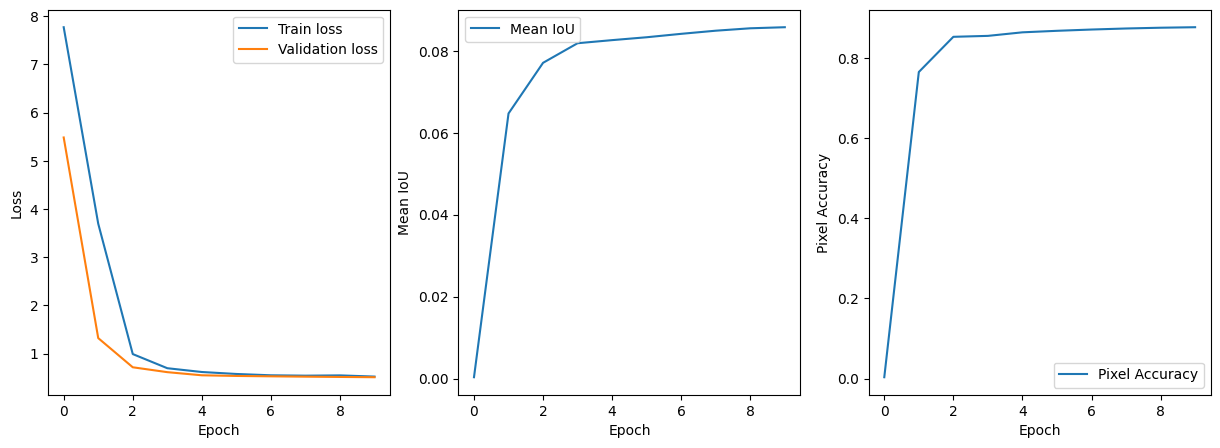

Best Mean IoU: 0.0858

Best batch_size: 16 | Mean IoU: 0.09184119289400322

Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 1/10
Train loss: 3.8427 | Validation loss: 0.9609
Mean IoU: 0.0682 | Pixel accuracy: 0.8281


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 2/10
Train loss: 0.7733 | Validation loss: 0.6477
Mean IoU: 0.0779 | Pixel accuracy: 0.8428


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 3/10
Train loss: 0.5758 | Validation loss: 0.5283
Mean IoU: 0.0804 | Pixel accuracy: 0.8706


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 4/10
Train loss: 0.5949 | Validation loss: 0.4726
Mean IoU: 0.0832 | Pixel accuracy: 0.8686


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch 5/10
Train loss: 0.4532 | Validation loss: 0.4306
Mean IoU: 0.0860 | Pixel accuracy: 0.8769


100%|██████████| 6/6 [00:11<00:00,  1.94s/it]


Epoch 6/10
Train loss: 0.4743 | Validation loss: 0.4220
Mean IoU: 0.0863 | Pixel accuracy: 0.8779


100%|██████████| 6/6 [00:11<00:00,  1.95s/it]


Epoch 7/10
Train loss: 0.4278 | Validation loss: 0.4154
Mean IoU: 0.0855 | Pixel accuracy: 0.8794


100%|██████████| 6/6 [00:12<00:00,  2.00s/it]


Epoch 8/10
Train loss: 0.4111 | Validation loss: 0.4131
Mean IoU: 0.0851 | Pixel accuracy: 0.8801


100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch 9/10
Train loss: 0.4086 | Validation loss: 0.4103
Mean IoU: 0.0852 | Pixel accuracy: 0.8803


100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Epoch 10/10
Train loss: 0.4001 | Validation loss: 0.4072
Mean IoU: 0.0854 | Pixel accuracy: 0.8815
Training time: 152.01 seconds


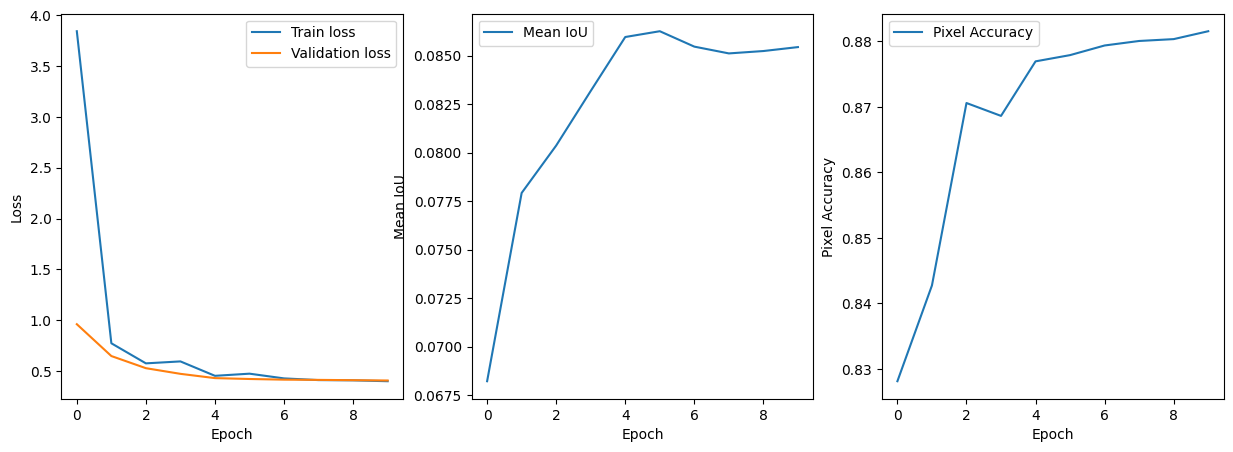

Best Mean IoU: 0.0863
Training and evaluating fpn with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: ExponentialLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.ExponentialLR'>, 'gamma': 0.95}



100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 1/10
Train loss: 6.0528 | Validation loss: 1.4753
Mean IoU: 0.0451 | Pixel accuracy: 0.6896


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 2/10
Train loss: 1.0847 | Validation loss: 0.6963
Mean IoU: 0.0732 | Pixel accuracy: 0.8528


100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


Epoch 3/10
Train loss: 0.6379 | Validation loss: 0.5548
Mean IoU: 0.0824 | Pixel accuracy: 0.8565


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 4/10
Train loss: 0.5439 | Validation loss: 0.4839
Mean IoU: 0.0804 | Pixel accuracy: 0.8716


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 5/10
Train loss: 0.4840 | Validation loss: 0.4365
Mean IoU: 0.0818 | Pixel accuracy: 0.8800


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 6/10
Train loss: 0.5300 | Validation loss: 0.4280
Mean IoU: 0.0832 | Pixel accuracy: 0.8814


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 7/10
Train loss: 0.4189 | Validation loss: 0.4203
Mean IoU: 0.0842 | Pixel accuracy: 0.8822


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 8/10
Train loss: 0.4278 | Validation loss: 0.4168
Mean IoU: 0.0851 | Pixel accuracy: 0.8827


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 9/10
Train loss: 0.4176 | Validation loss: 0.4139
Mean IoU: 0.0858 | Pixel accuracy: 0.8833


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 10/10
Train loss: 0.4147 | Validation loss: 0.4126
Mean IoU: 0.0867 | Pixel accuracy: 0.8855
Training time: 151.47 seconds


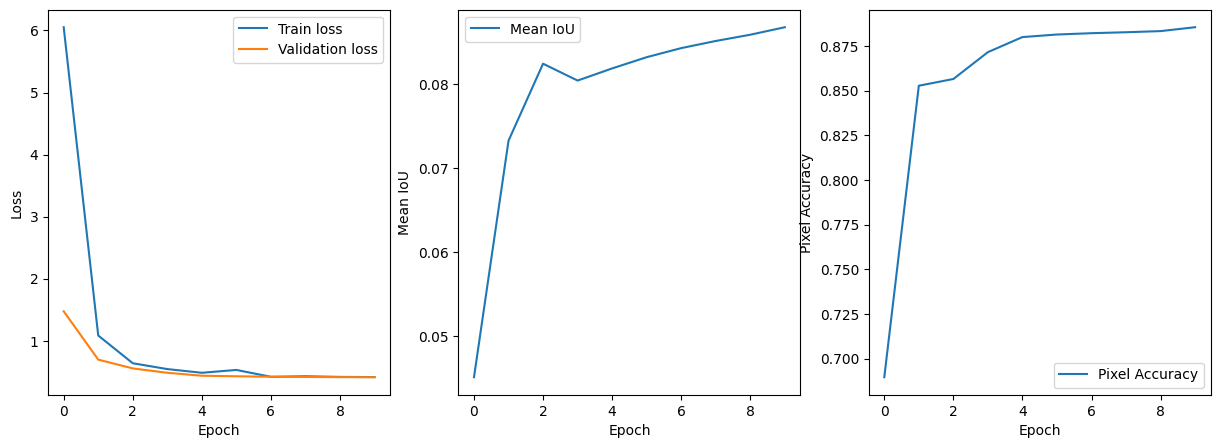

Best Mean IoU: 0.0867

Best scheduler: {'scheduler': <class 'torch.optim.lr_scheduler.ExponentialLR'>, 'gamma': 0.95} | Mean IoU: 0.08672628086839984


Best performance for fpn
Encoder: resnet50 | Weights: imagenet | Activation: None
Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
Scheduler: ExponentialLR | Mean IoU: 0.08672628086839984


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 1/10
Train loss: 4.1220 | Validation loss: 1.0318
Mean IoU: 0.0679 | Pixel accuracy: 0.8334


100%|██████████| 6/6 [00:12<00:00,  2.17s/it]


Epoch 2/10
Train loss: 0.8750 | Validation loss: 0.6580
Mean IoU: 0.0757 | Pixel accuracy: 0.8625


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 3/10
Train loss: 0.6442 | Validation loss: 0.5575
Mean IoU: 0.0790 | Pixel accuracy: 0.8645


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 4/10
Train loss: 0.5230 | Validation loss: 0.4625
Mean IoU: 0.0883 | Pixel accuracy: 0.8773


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 5/10
Train loss: 0.4621 | Validation loss: 0.4302
Mean IoU: 0.0844 | Pixel accuracy: 0.8770


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 6/10
Train loss: 0.4072 | Validation loss: 0.4187
Mean IoU: 0.0856 | Pixel accuracy: 0.8804


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 7/10
Train loss: 0.4208 | Validation loss: 0.4102
Mean IoU: 0.0871 | Pixel accuracy: 0.8829


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 8/10
Train loss: 0.4185 | Validation loss: 0.4036
Mean IoU: 0.0885 | Pixel accuracy: 0.8845


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 9/10
Train loss: 0.4464 | Validation loss: 0.3967
Mean IoU: 0.0900 | Pixel accuracy: 0.8868


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch 10/10
Train loss: 0.4022 | Validation loss: 0.3958
Mean IoU: 0.0901 | Pixel accuracy: 0.8865
Training time: 153.06 seconds


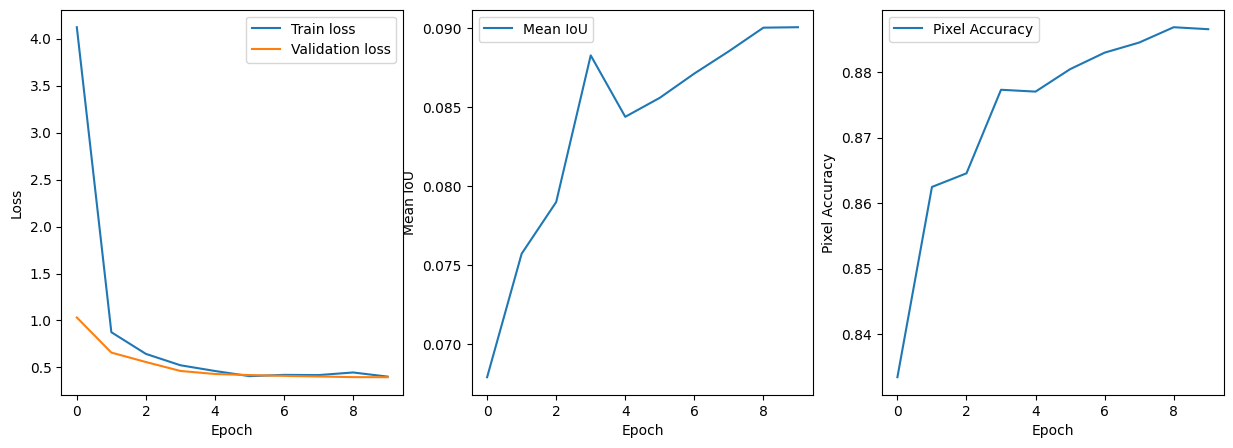

Best Mean IoU: 0.0901


In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 10

    model_info_list = [
        {"name": "fpn", "model": smp.FPN}
    ]

    best_parameters_list = [] 

    for model_info in model_info_list:

        best_parameters = {
            "encoder_name": "resnet50",
            "encoder_weights": None,
            "activation": None,
            "learning_rate": 1e-4,
            "optimizer": optim.Adam,
            "batch_size": 16,
            "scheduler": {"scheduler": optim.lr_scheduler.StepLR, "step_size": 5, "gamma": 0.1},
            "mean_iou": 0
        }

        # Hyperparameters to explore
        encoder_names = ['resnet50', 'resnet101']
        encoder_weights = [None, 'imagenet']
        activation_functions = [None, 'sigmoid', 'softmax2d']
        learning_rates = [1e-4, 5e-5]
        optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
        batch_sizes = [16, 32]
        scheduler_options = [
            {"scheduler": optim.lr_scheduler.StepLR, "step_size": 5, "gamma": 0.1},
            {"scheduler": optim.lr_scheduler.ExponentialLR, "gamma": 0.95}
        ]

        hyperparameter_lists = [
            ("encoder_name", encoder_names),
            ("encoder_weights", encoder_weights),
            ("activation", activation_functions),
            ("learning_rate", learning_rates),
            ("optimizer", optimizers),
            ("batch_size", batch_sizes),
            ("scheduler", scheduler_options)
        ]

        for hyperparameter_name, hyperparameter_values in hyperparameter_lists:
            best_hyperparameter_value = None
            best_hyperparameter_iou = 0

            for hyperparameter_value in hyperparameter_values:
                current_parameters = best_parameters.copy()
                current_parameters[hyperparameter_name] = hyperparameter_value

                print(f"Training and evaluating {model_info['name']} with the following hyperparameters:")
                print(f"  Encoder: {current_parameters['encoder_name']} | Weights: {current_parameters['encoder_weights']} | Activation: {current_parameters['activation']}")
                print(f"  Learning rate: {current_parameters['learning_rate']} | Optimizer: {current_parameters['optimizer'].__name__} | Batch size: {current_parameters['batch_size']}")
                print(f"  Scheduler: {current_parameters['scheduler']['scheduler'].__name__} | Params: {current_parameters['scheduler']}\n")

                model = model_info["model"](encoder_name=current_parameters["encoder_name"],
                                             encoder_weights=current_parameters["encoder_weights"],
                                             classes=32,
                                             activation=current_parameters["activation"]).to(device)

                train_loader = DataLoader(train_dataset, batch_size=current_parameters["batch_size"], shuffle=True, num_workers=2)
                val_loader = DataLoader(val_dataset, batch_size=current_parameters["batch_size"], shuffle=False, num_workers=2)

                mean_iou = train_and_evaluate(model, train_loader, val_loader, epochs,
                                              current_parameters["learning_rate"],
                                              current_parameters["optimizer"],
                                              device, model_info["name"],
                                              current_parameters["scheduler"])

                if mean_iou > best_hyperparameter_iou:
                    best_hyperparameter_iou = mean_iou
                    best_hyperparameter_value = hyperparameter_value

            best_parameters[hyperparameter_name] = best_hyperparameter_value
            best_parameters["mean_iou"] = best_hyperparameter_iou
            print(f"\nBest {hyperparameter_name}: {best_hyperparameter_value} | Mean IoU: {best_hyperparameter_iou}\n")

        print("\nBest performance for", model_info["name"])
        print(f"Encoder: {best_parameters['encoder_name']} | Weights: {best_parameters['encoder_weights']} | Activation: {best_parameters['activation']}")
        print(f"Learning rate: {best_parameters['learning_rate']} | Optimizer: {best_parameters['optimizer'].__name__} | Batch size: {best_parameters['batch_size']}")
        print(f"Scheduler: {best_parameters['scheduler']['scheduler'].__name__} | Mean IoU: {best_parameters['mean_iou']}")

        # Train the model with the best hyperparameters
        model = model_info["model"](encoder_name=best_parameters["encoder_name"],
                                     encoder_weights=best_parameters["encoder_weights"],
                                     classes=32,
                                     activation=best_parameters["activation"]).to(device)

        train_loader = DataLoader(train_dataset, batch_size=best_parameters["batch_size"], shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=best_parameters["batch_size"], shuffle=False, num_workers=2)

        train_and_evaluate(model, train_loader, val_loader, epochs,
                           best_parameters["learning_rate"],
                           best_parameters["optimizer"],
                           device, model_info["name"],
                           best_parameters["scheduler"])

        # Save the model state dict
        torch.save(model.state_dict(), f"best_model_{model_info['name']}.pth")

        # Add the best parameters for the model to the list
        best_parameters["name"] = model_info["name"]
        best_parameters_list.append(best_parameters.copy())

    # Return the list of best parameters
    return best_parameters_list


if __name__ == "__main__":
    best_parameters_list_fpn = main()

    with open('best_parameters_list_fpn.pkl', 'wb') as f:
      pickle.dump(best_parameters_list_fpn, f)

> 5.3.

*   Train and Evaluate PSPNet model
*   Explore best hyperparameters



Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 1/10
Train loss: 2.5850 | Validation loss: 2.7094
Mean IoU: 0.0290 | Pixel accuracy: 0.3252


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 2/10
Train loss: 1.2340 | Validation loss: 2.3878
Mean IoU: 0.0107 | Pixel accuracy: 0.2663


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 3/10
Train loss: 0.7880 | Validation loss: 1.9471
Mean IoU: 0.0318 | Pixel accuracy: 0.3364


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 4/10
Train loss: 0.6096 | Validation loss: 1.4335
Mean IoU: 0.0423 | Pixel accuracy: 0.5131


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 5/10
Train loss: 0.5753 | Validation loss: 0.7224
Mean IoU: 0.0653 | Pixel accuracy: 0.7957


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 6/10
Train loss: 0.5121 | Validation loss: 0.6092
Mean IoU: 0.0719 | Pixel accuracy: 0.8349


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 7/10
Train loss: 0.5192 | Validation loss: 0.5525
Mean IoU: 0.0751 | Pixel accuracy: 0.8524


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 8/10
Train loss: 0.4956 | Validation loss: 0.5394
Mean IoU: 0.0750 | Pixel accuracy: 0.8481


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 9/10
Train loss: 0.4822 | Validation loss: 0.5306
Mean IoU: 0.0751 | Pixel accuracy: 0.8482


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 10/10
Train loss: 0.4787 | Validation loss: 0.5236
Mean IoU: 0.0754 | Pixel accuracy: 0.8494
Training time: 149.19 seconds


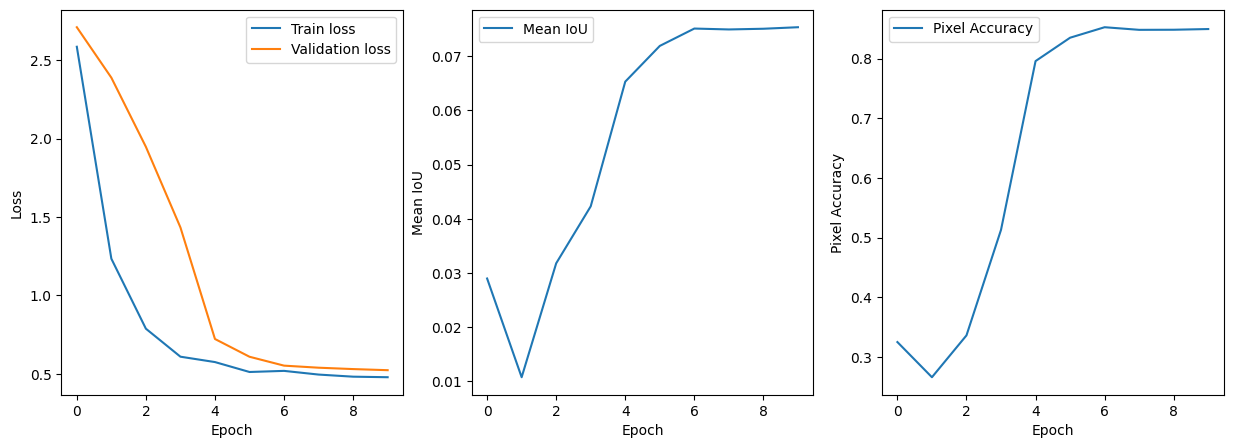

Best Mean IoU: 0.0754
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet101 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 1/10
Train loss: 2.6927 | Validation loss: 2.9685
Mean IoU: 0.0134 | Pixel accuracy: 0.2666


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 2/10
Train loss: 1.2881 | Validation loss: 2.3123
Mean IoU: 0.0255 | Pixel accuracy: 0.3093


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 3/10
Train loss: 0.7717 | Validation loss: 1.8632
Mean IoU: 0.0336 | Pixel accuracy: 0.3561


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 4/10
Train loss: 0.6605 | Validation loss: 1.8743
Mean IoU: 0.0450 | Pixel accuracy: 0.5416


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 5/10
Train loss: 0.5788 | Validation loss: 0.7239
Mean IoU: 0.0662 | Pixel accuracy: 0.7909


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 6/10
Train loss: 0.5374 | Validation loss: 0.6048
Mean IoU: 0.0731 | Pixel accuracy: 0.8430


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 7/10
Train loss: 0.4929 | Validation loss: 0.5607
Mean IoU: 0.0741 | Pixel accuracy: 0.8460


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 8/10
Train loss: 0.5009 | Validation loss: 0.5533
Mean IoU: 0.0734 | Pixel accuracy: 0.8403


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 9/10
Train loss: 0.5050 | Validation loss: 0.5551
Mean IoU: 0.0730 | Pixel accuracy: 0.8370


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 10/10
Train loss: 0.4984 | Validation loss: 0.5539
Mean IoU: 0.0729 | Pixel accuracy: 0.8353
Training time: 154.48 seconds


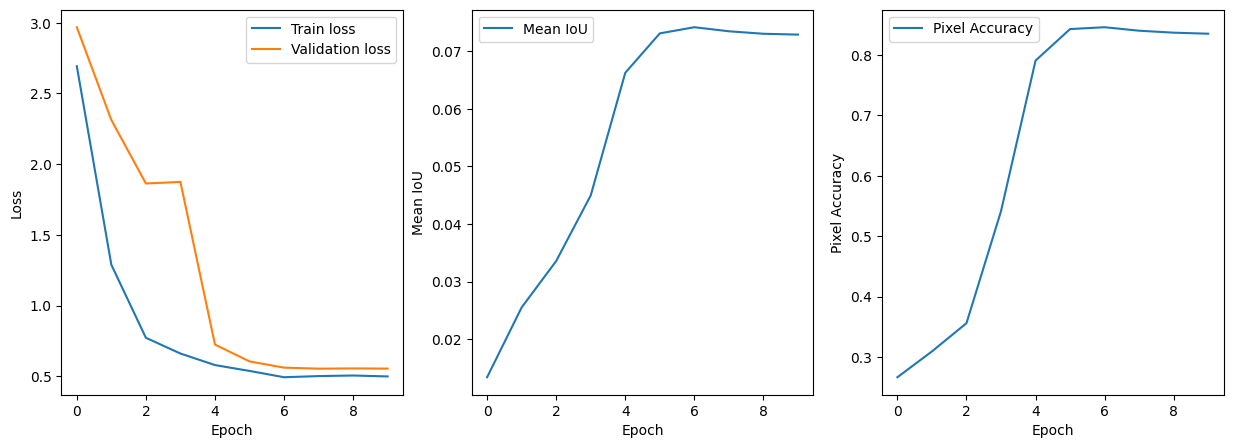

Best Mean IoU: 0.0741

Best encoder_name: resnet50 | Mean IoU: 0.0753756519656618

Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: None | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 1/10
Train loss: 2.8619 | Validation loss: 2.9442
Mean IoU: 0.0081 | Pixel accuracy: 0.2590


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 2/10
Train loss: 1.4534 | Validation loss: 2.6732
Mean IoU: 0.0081 | Pixel accuracy: 0.2587


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 3/10
Train loss: 0.9047 | Validation loss: 1.8568
Mean IoU: 0.0142 | Pixel accuracy: 0.3302


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 4/10
Train loss: 0.6603 | Validation loss: 0.9628
Mean IoU: 0.0610 | Pixel accuracy: 0.7383


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 5/10
Train loss: 0.5496 | Validation loss: 0.7482
Mean IoU: 0.0685 | Pixel accuracy: 0.8182


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 6/10
Train loss: 0.5271 | Validation loss: 0.7084
Mean IoU: 0.0692 | Pixel accuracy: 0.8228


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 7/10
Train loss: 0.5197 | Validation loss: 0.6431
Mean IoU: 0.0713 | Pixel accuracy: 0.8296


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch 8/10
Train loss: 0.5140 | Validation loss: 0.5768
Mean IoU: 0.0731 | Pixel accuracy: 0.8402


100%|██████████| 6/6 [00:12<00:00,  2.00s/it]


Epoch 9/10
Train loss: 0.5075 | Validation loss: 0.5347
Mean IoU: 0.0745 | Pixel accuracy: 0.8479


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 10/10
Train loss: 0.4917 | Validation loss: 0.5293
Mean IoU: 0.0747 | Pixel accuracy: 0.8477
Training time: 154.41 seconds


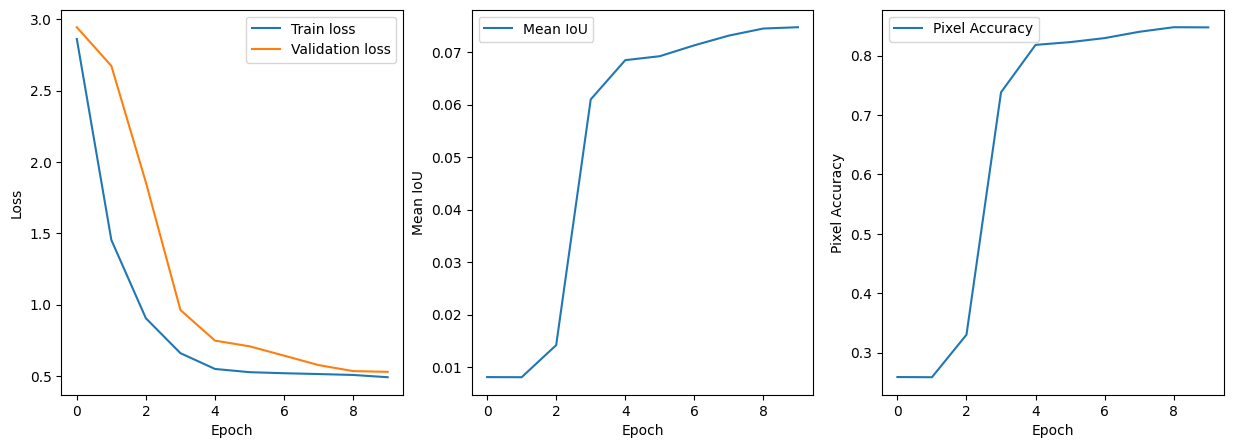

Best Mean IoU: 0.0747
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 1/10
Train loss: 2.5306 | Validation loss: 2.9514
Mean IoU: 0.0356 | Pixel accuracy: 0.5938


100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch 2/10
Train loss: 0.9958 | Validation loss: 2.2489
Mean IoU: 0.0617 | Pixel accuracy: 0.7791


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 3/10
Train loss: 0.6347 | Validation loss: 1.5780
Mean IoU: 0.0654 | Pixel accuracy: 0.8084


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 4/10
Train loss: 0.5048 | Validation loss: 1.1350
Mean IoU: 0.0696 | Pixel accuracy: 0.8317


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 5/10
Train loss: 0.4559 | Validation loss: 0.8478
Mean IoU: 0.0757 | Pixel accuracy: 0.8585


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 6/10
Train loss: 0.4234 | Validation loss: 0.6927
Mean IoU: 0.0780 | Pixel accuracy: 0.8667


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 7/10
Train loss: 0.4375 | Validation loss: 0.5811
Mean IoU: 0.0794 | Pixel accuracy: 0.8709


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 8/10
Train loss: 0.4542 | Validation loss: 0.5043
Mean IoU: 0.0798 | Pixel accuracy: 0.8722


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch 9/10
Train loss: 0.4080 | Validation loss: 0.4587
Mean IoU: 0.0805 | Pixel accuracy: 0.8751


100%|██████████| 6/6 [00:12<00:00,  2.15s/it]


Epoch 10/10
Train loss: 0.3953 | Validation loss: 0.4362
Mean IoU: 0.0808 | Pixel accuracy: 0.8764
Training time: 147.95 seconds


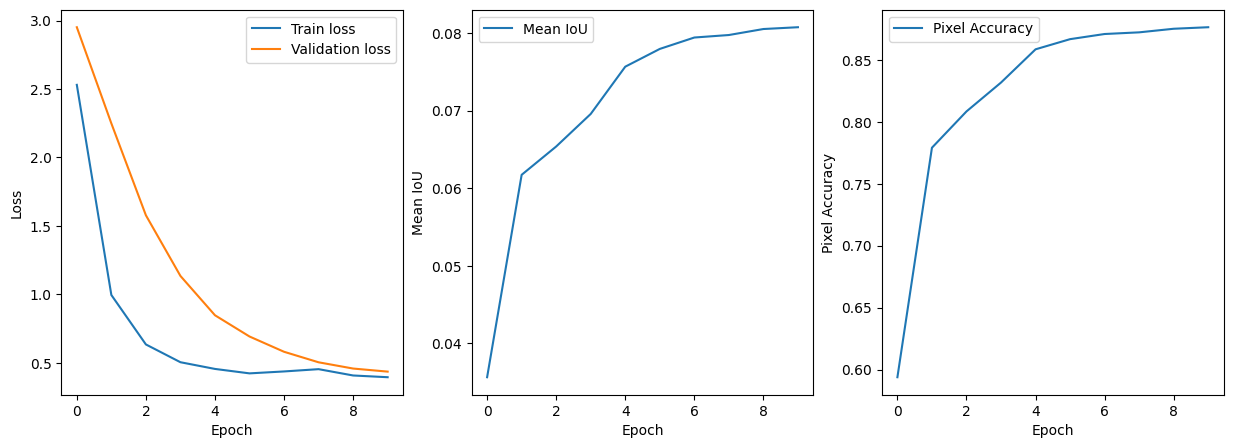

Best Mean IoU: 0.0808

Best encoder_weights: imagenet | Mean IoU: 0.0807579386993063

Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 1/10
Train loss: 3.0591 | Validation loss: 3.0360
Mean IoU: 0.0223 | Pixel accuracy: 0.2761


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 2/10
Train loss: 1.2686 | Validation loss: 2.2846
Mean IoU: 0.0642 | Pixel accuracy: 0.7681


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 3/10
Train loss: 0.8097 | Validation loss: 1.5833
Mean IoU: 0.0686 | Pixel accuracy: 0.8024


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 4/10
Train loss: 0.5483 | Validation loss: 1.1042
Mean IoU: 0.0714 | Pixel accuracy: 0.8251


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 5/10
Train loss: 0.4899 | Validation loss: 0.8072
Mean IoU: 0.0745 | Pixel accuracy: 0.8374


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 6/10
Train loss: 0.4748 | Validation loss: 0.6633
Mean IoU: 0.0770 | Pixel accuracy: 0.8530


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 7/10
Train loss: 0.4455 | Validation loss: 0.5702
Mean IoU: 0.0798 | Pixel accuracy: 0.8658


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 8/10
Train loss: 0.4549 | Validation loss: 0.5069
Mean IoU: 0.0810 | Pixel accuracy: 0.8722


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 9/10
Train loss: 0.4532 | Validation loss: 0.4685
Mean IoU: 0.0808 | Pixel accuracy: 0.8754


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 10/10
Train loss: 0.4367 | Validation loss: 0.4470
Mean IoU: 0.0807 | Pixel accuracy: 0.8768
Training time: 155.19 seconds


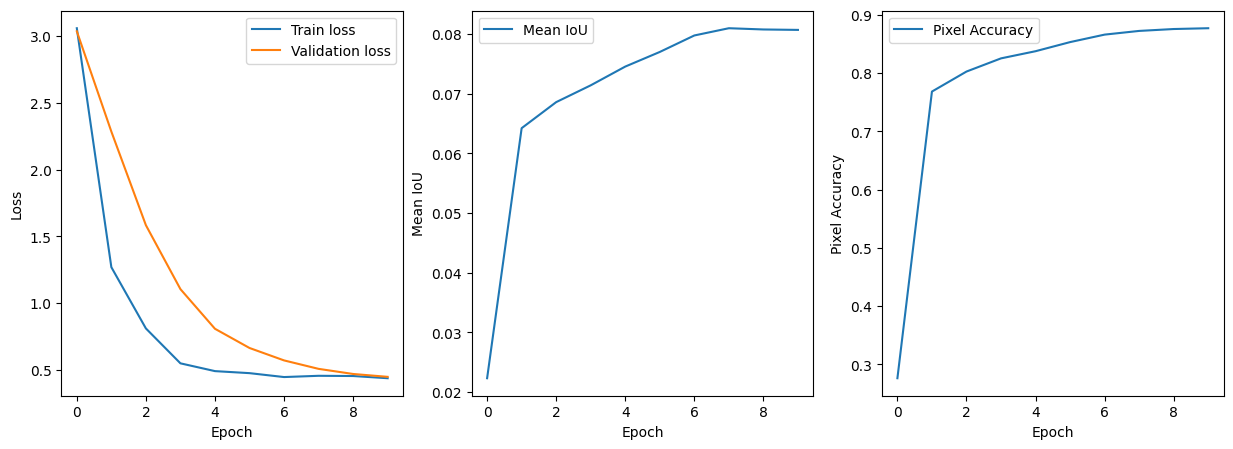

Best Mean IoU: 0.0810
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: sigmoid
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 1/10
Train loss: 3.2604 | Validation loss: 3.2986
Mean IoU: 0.0326 | Pixel accuracy: 0.6420


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 2/10
Train loss: 2.8942 | Validation loss: 3.0601
Mean IoU: 0.0419 | Pixel accuracy: 0.7281


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch 3/10
Train loss: 2.7402 | Validation loss: 2.8626
Mean IoU: 0.0478 | Pixel accuracy: 0.7540


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch 4/10
Train loss: 2.6691 | Validation loss: 2.7524
Mean IoU: 0.0561 | Pixel accuracy: 0.7815


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch 5/10
Train loss: 2.6368 | Validation loss: 2.6945
Mean IoU: 0.0614 | Pixel accuracy: 0.7991


100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch 6/10
Train loss: 2.6356 | Validation loss: 2.6732
Mean IoU: 0.0659 | Pixel accuracy: 0.8104


100%|██████████| 6/6 [00:12<00:00,  2.00s/it]


Epoch 7/10
Train loss: 2.6350 | Validation loss: 2.6574
Mean IoU: 0.0686 | Pixel accuracy: 0.8173


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 8/10
Train loss: 2.6243 | Validation loss: 2.6458
Mean IoU: 0.0699 | Pixel accuracy: 0.8212


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch 9/10
Train loss: 2.6225 | Validation loss: 2.6380
Mean IoU: 0.0703 | Pixel accuracy: 0.8225


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 10/10
Train loss: 2.6227 | Validation loss: 2.6312
Mean IoU: 0.0704 | Pixel accuracy: 0.8243
Training time: 152.54 seconds


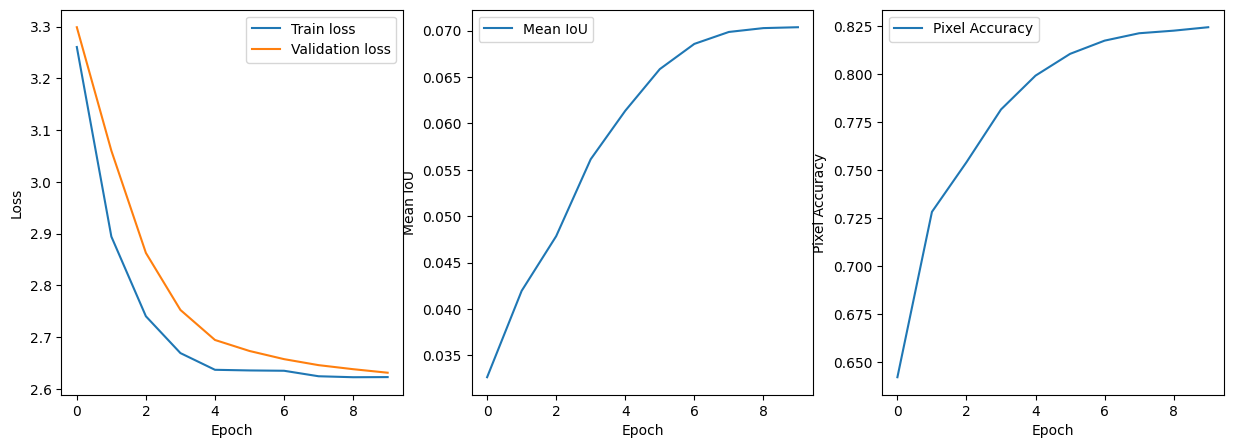

Best Mean IoU: 0.0704
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: softmax2d
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 1/10
Train loss: 3.3306 | Validation loss: 3.4393
Mean IoU: 0.0300 | Pixel accuracy: 0.4900


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 2/10
Train loss: 3.0477 | Validation loss: 3.2943
Mean IoU: 0.0534 | Pixel accuracy: 0.7097


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 3/10
Train loss: 2.8304 | Validation loss: 2.9999
Mean IoU: 0.0563 | Pixel accuracy: 0.7525


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 4/10
Train loss: 2.7372 | Validation loss: 2.8185
Mean IoU: 0.0638 | Pixel accuracy: 0.7898


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 5/10
Train loss: 2.7115 | Validation loss: 2.7531
Mean IoU: 0.0683 | Pixel accuracy: 0.8019


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 6/10
Train loss: 2.6978 | Validation loss: 2.7383
Mean IoU: 0.0688 | Pixel accuracy: 0.8029


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 7/10
Train loss: 2.7019 | Validation loss: 2.7291
Mean IoU: 0.0695 | Pixel accuracy: 0.8058


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 8/10
Train loss: 2.6995 | Validation loss: 2.7228
Mean IoU: 0.0699 | Pixel accuracy: 0.8084


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 9/10
Train loss: 2.6916 | Validation loss: 2.7150
Mean IoU: 0.0708 | Pixel accuracy: 0.8141


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 10/10
Train loss: 2.6882 | Validation loss: 2.7118
Mean IoU: 0.0709 | Pixel accuracy: 0.8156
Training time: 155.96 seconds


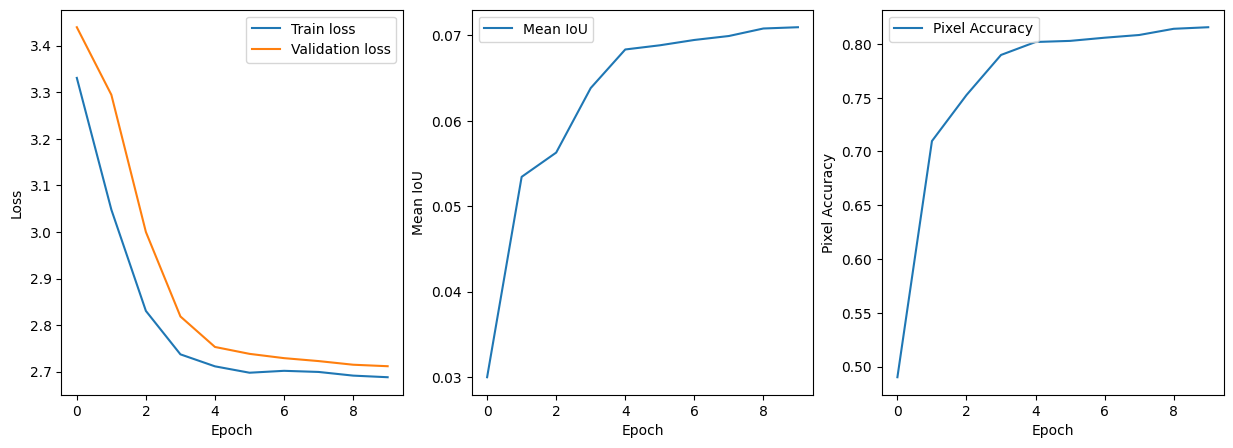

Best Mean IoU: 0.0709

Best activation: None | Mean IoU: 0.08096687459494986

Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 1/10
Train loss: 2.5123 | Validation loss: 2.9230
Mean IoU: 0.0430 | Pixel accuracy: 0.6556


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 2/10
Train loss: 1.0059 | Validation loss: 2.1090
Mean IoU: 0.0574 | Pixel accuracy: 0.7731


100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


Epoch 3/10
Train loss: 0.6386 | Validation loss: 1.4665
Mean IoU: 0.0612 | Pixel accuracy: 0.7973


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 4/10
Train loss: 0.5145 | Validation loss: 1.0596
Mean IoU: 0.0685 | Pixel accuracy: 0.8345


100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


Epoch 5/10
Train loss: 0.4744 | Validation loss: 0.7712
Mean IoU: 0.0751 | Pixel accuracy: 0.8614


100%|██████████| 6/6 [00:11<00:00,  1.98s/it]


Epoch 6/10
Train loss: 0.4506 | Validation loss: 0.6270
Mean IoU: 0.0773 | Pixel accuracy: 0.8703


100%|██████████| 6/6 [00:11<00:00,  2.00s/it]


Epoch 7/10
Train loss: 0.4428 | Validation loss: 0.5333
Mean IoU: 0.0784 | Pixel accuracy: 0.8748


100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


Epoch 8/10
Train loss: 0.4257 | Validation loss: 0.4789
Mean IoU: 0.0790 | Pixel accuracy: 0.8768


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 9/10
Train loss: 0.4240 | Validation loss: 0.4492
Mean IoU: 0.0795 | Pixel accuracy: 0.8774


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 10/10
Train loss: 0.4472 | Validation loss: 0.4357
Mean IoU: 0.0795 | Pixel accuracy: 0.8774
Training time: 152.69 seconds


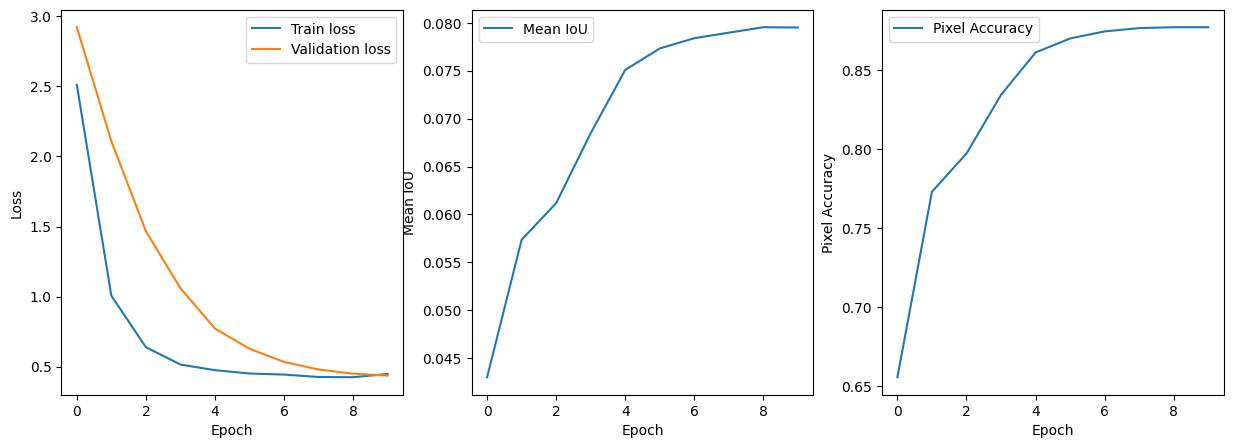

Best Mean IoU: 0.0795
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 5e-05 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 1/10
Train loss: 2.8281 | Validation loss: 2.9193
Mean IoU: 0.0229 | Pixel accuracy: 0.5500


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 2/10
Train loss: 1.5083 | Validation loss: 2.3204
Mean IoU: 0.0304 | Pixel accuracy: 0.6185


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 3/10
Train loss: 0.9835 | Validation loss: 1.7073
Mean IoU: 0.0385 | Pixel accuracy: 0.6584


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 4/10
Train loss: 0.7784 | Validation loss: 1.2544
Mean IoU: 0.0564 | Pixel accuracy: 0.7442


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 5/10
Train loss: 0.6880 | Validation loss: 0.9628
Mean IoU: 0.0659 | Pixel accuracy: 0.8006


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 6/10
Train loss: 0.6165 | Validation loss: 0.8221
Mean IoU: 0.0703 | Pixel accuracy: 0.8273


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 7/10
Train loss: 0.5813 | Validation loss: 0.7279
Mean IoU: 0.0723 | Pixel accuracy: 0.8394


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 8/10
Train loss: 0.5657 | Validation loss: 0.6729
Mean IoU: 0.0728 | Pixel accuracy: 0.8416


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 9/10
Train loss: 0.5661 | Validation loss: 0.6353
Mean IoU: 0.0732 | Pixel accuracy: 0.8406


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 10/10
Train loss: 0.5409 | Validation loss: 0.6107
Mean IoU: 0.0737 | Pixel accuracy: 0.8411
Training time: 154.95 seconds


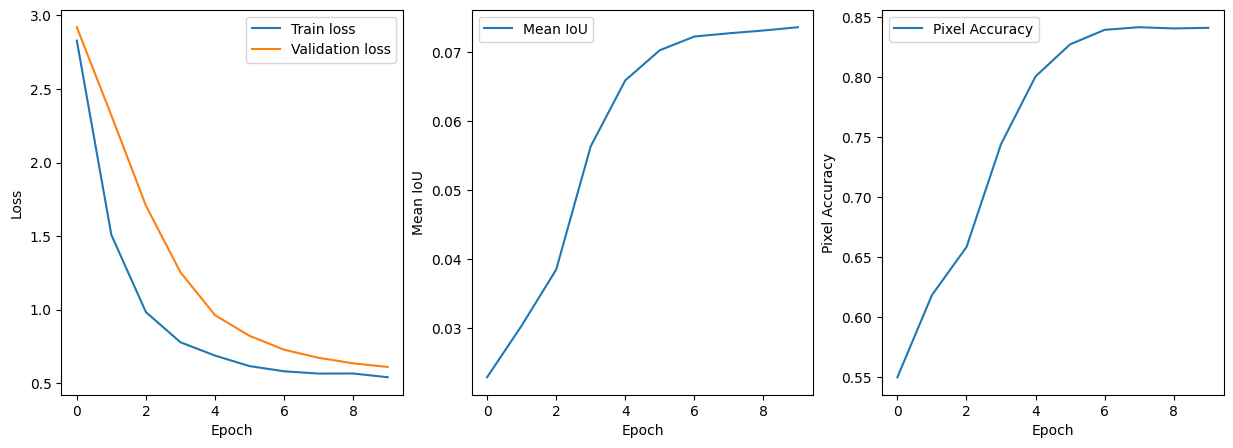

Best Mean IoU: 0.0737

Best learning_rate: 0.0001 | Mean IoU: 0.079539554476636

Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: Adam | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 1/10
Train loss: 2.1881 | Validation loss: 2.7736
Mean IoU: 0.0343 | Pixel accuracy: 0.6371


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 2/10
Train loss: 0.8771 | Validation loss: 1.9983
Mean IoU: 0.0506 | Pixel accuracy: 0.7276


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 3/10
Train loss: 0.6231 | Validation loss: 1.3749
Mean IoU: 0.0575 | Pixel accuracy: 0.7659


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 4/10
Train loss: 0.5149 | Validation loss: 0.9861
Mean IoU: 0.0630 | Pixel accuracy: 0.7962


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch 5/10
Train loss: 0.4525 | Validation loss: 0.7285
Mean IoU: 0.0702 | Pixel accuracy: 0.8349


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 6/10
Train loss: 0.4240 | Validation loss: 0.6124
Mean IoU: 0.0736 | Pixel accuracy: 0.8504


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 7/10
Train loss: 0.4239 | Validation loss: 0.5380
Mean IoU: 0.0760 | Pixel accuracy: 0.8601


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 8/10
Train loss: 0.4283 | Validation loss: 0.4879
Mean IoU: 0.0778 | Pixel accuracy: 0.8673


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 9/10
Train loss: 0.4250 | Validation loss: 0.4544
Mean IoU: 0.0791 | Pixel accuracy: 0.8722


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch 10/10
Train loss: 0.4275 | Validation loss: 0.4385
Mean IoU: 0.0789 | Pixel accuracy: 0.8721
Training time: 154.57 seconds


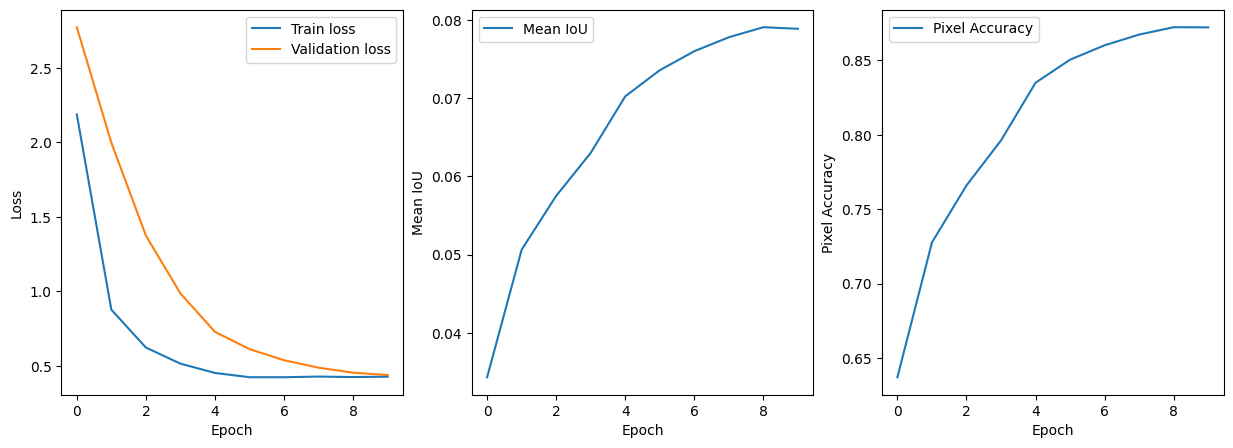

Best Mean IoU: 0.0791
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: SGD | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 1/10
Train loss: 2.3955 | Validation loss: 2.7676
Mean IoU: 0.0608 | Pixel accuracy: 0.7533


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 2/10
Train loss: 1.0081 | Validation loss: 2.0092
Mean IoU: 0.0658 | Pixel accuracy: 0.7922


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 3/10
Train loss: 0.6613 | Validation loss: 1.3846
Mean IoU: 0.0663 | Pixel accuracy: 0.8072


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 4/10
Train loss: 0.5307 | Validation loss: 0.9796
Mean IoU: 0.0706 | Pixel accuracy: 0.8389


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 5/10
Train loss: 0.4811 | Validation loss: 0.7166
Mean IoU: 0.0745 | Pixel accuracy: 0.8540


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 6/10
Train loss: 0.4268 | Validation loss: 0.6017
Mean IoU: 0.0767 | Pixel accuracy: 0.8656


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 7/10
Train loss: 0.4288 | Validation loss: 0.5291
Mean IoU: 0.0779 | Pixel accuracy: 0.8714


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 8/10
Train loss: 0.4199 | Validation loss: 0.4834
Mean IoU: 0.0782 | Pixel accuracy: 0.8726


100%|██████████| 6/6 [00:14<00:00,  2.36s/it]


Epoch 9/10
Train loss: 0.4285 | Validation loss: 0.4563
Mean IoU: 0.0785 | Pixel accuracy: 0.8740


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 10/10
Train loss: 0.4205 | Validation loss: 0.4419
Mean IoU: 0.0787 | Pixel accuracy: 0.8747
Training time: 154.59 seconds


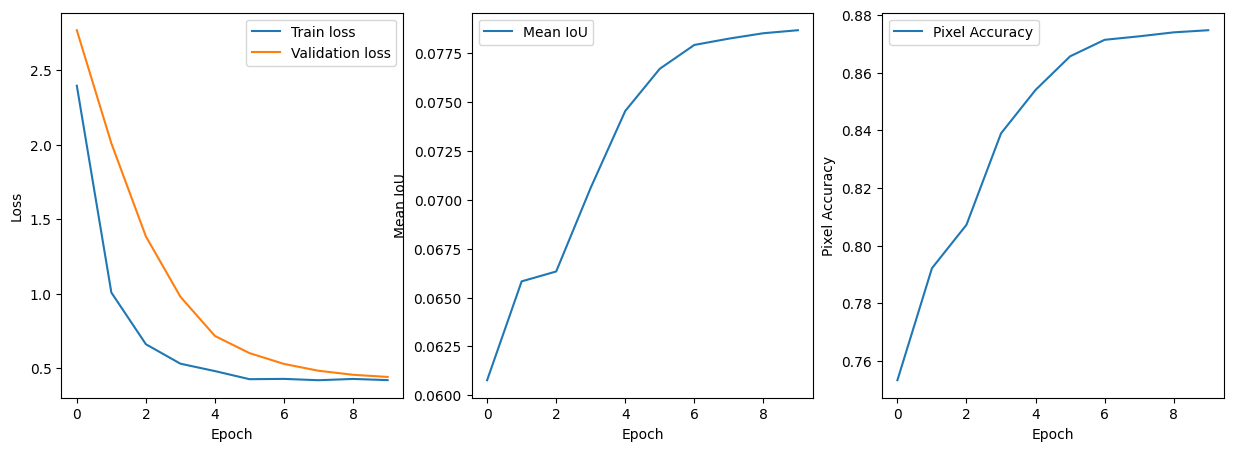

Best Mean IoU: 0.0787
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: RMSprop | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 1/10
Train loss: 2.8166 | Validation loss: 3.0243
Mean IoU: 0.0338 | Pixel accuracy: 0.4651


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 2/10
Train loss: 1.1643 | Validation loss: 2.2120
Mean IoU: 0.0688 | Pixel accuracy: 0.8036


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 3/10
Train loss: 0.7429 | Validation loss: 1.5041
Mean IoU: 0.0695 | Pixel accuracy: 0.8180


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 4/10
Train loss: 0.5970 | Validation loss: 1.0544
Mean IoU: 0.0744 | Pixel accuracy: 0.8540


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch 5/10
Train loss: 0.4719 | Validation loss: 0.7915
Mean IoU: 0.0776 | Pixel accuracy: 0.8687


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch 6/10
Train loss: 0.4599 | Validation loss: 0.6362
Mean IoU: 0.0788 | Pixel accuracy: 0.8747


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch 7/10
Train loss: 0.4411 | Validation loss: 0.5474
Mean IoU: 0.0797 | Pixel accuracy: 0.8767


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 8/10
Train loss: 0.4329 | Validation loss: 0.4947
Mean IoU: 0.0798 | Pixel accuracy: 0.8762


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 9/10
Train loss: 0.4316 | Validation loss: 0.4625
Mean IoU: 0.0794 | Pixel accuracy: 0.8754


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch 10/10
Train loss: 0.4287 | Validation loss: 0.4448
Mean IoU: 0.0794 | Pixel accuracy: 0.8752
Training time: 154.88 seconds


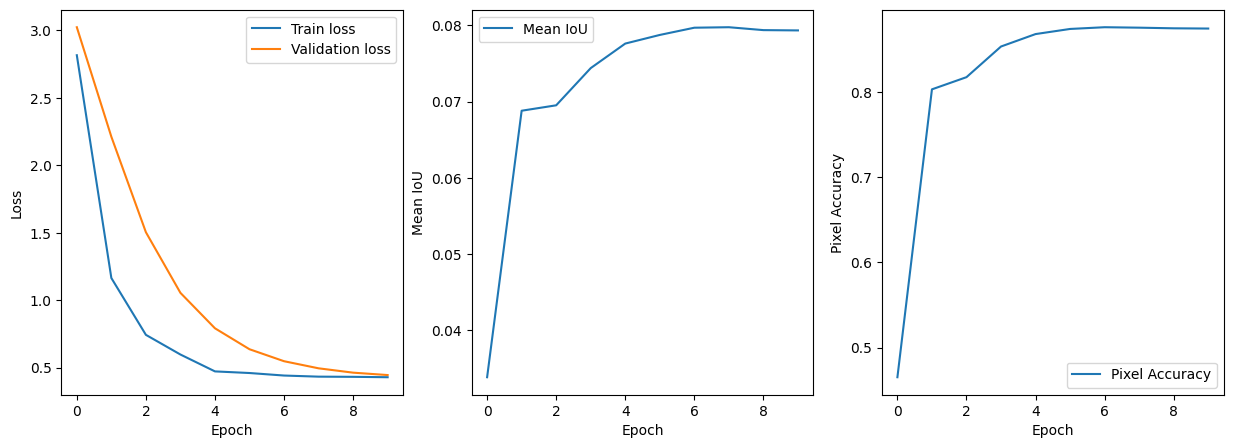

Best Mean IoU: 0.0798

Best optimizer: <class 'torch.optim.rmsprop.RMSprop'> | Mean IoU: 0.07977289799499716

Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: RMSprop | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 1/10
Train loss: 2.4709 | Validation loss: 2.7147
Mean IoU: 0.0505 | Pixel accuracy: 0.7244


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch 2/10
Train loss: 1.0519 | Validation loss: 1.8607
Mean IoU: 0.0529 | Pixel accuracy: 0.7679


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 3/10
Train loss: 0.6639 | Validation loss: 1.2529
Mean IoU: 0.0495 | Pixel accuracy: 0.7738


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 4/10
Train loss: 0.5157 | Validation loss: 0.9268
Mean IoU: 0.0580 | Pixel accuracy: 0.8080


100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 5/10
Train loss: 0.4610 | Validation loss: 0.7123
Mean IoU: 0.0669 | Pixel accuracy: 0.8283


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 6/10
Train loss: 0.4525 | Validation loss: 0.6032
Mean IoU: 0.0713 | Pixel accuracy: 0.8495


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 7/10
Train loss: 0.4513 | Validation loss: 0.5279
Mean IoU: 0.0755 | Pixel accuracy: 0.8646


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 8/10
Train loss: 0.4194 | Validation loss: 0.4823
Mean IoU: 0.0773 | Pixel accuracy: 0.8710


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 9/10
Train loss: 0.4259 | Validation loss: 0.4518
Mean IoU: 0.0784 | Pixel accuracy: 0.8734


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 10/10
Train loss: 0.4298 | Validation loss: 0.4352
Mean IoU: 0.0791 | Pixel accuracy: 0.8742
Training time: 155.81 seconds


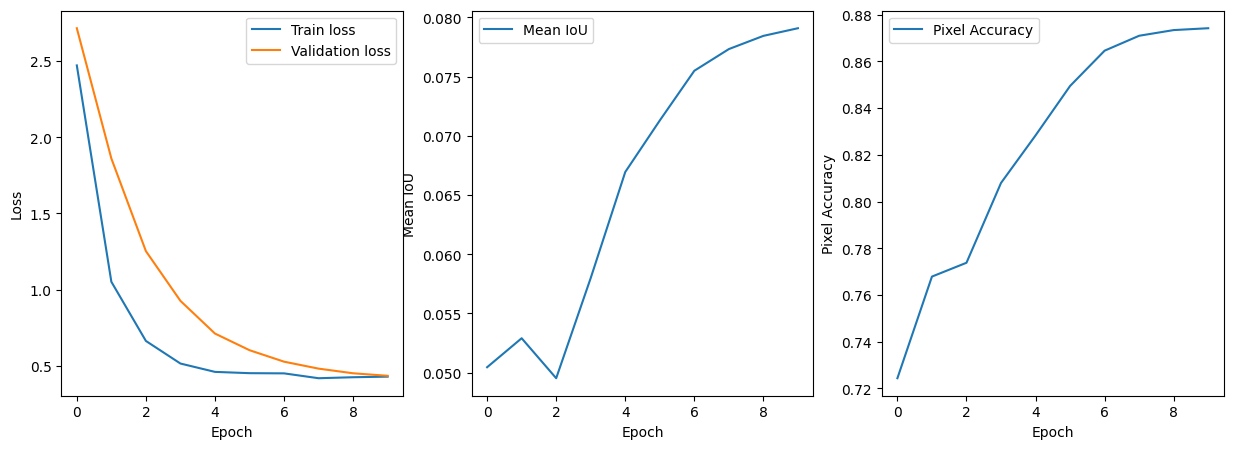

Best Mean IoU: 0.0791
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: RMSprop | Batch size: 32
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 3/3 [00:13<00:00,  4.53s/it]


Epoch 1/10
Train loss: 3.6232 | Validation loss: 3.2136
Mean IoU: 0.0229 | Pixel accuracy: 0.2621


100%|██████████| 3/3 [00:13<00:00,  4.59s/it]


Epoch 2/10
Train loss: 2.0925 | Validation loss: 2.8244
Mean IoU: 0.0523 | Pixel accuracy: 0.7279


100%|██████████| 3/3 [00:13<00:00,  4.54s/it]


Epoch 3/10
Train loss: 1.2579 | Validation loss: 2.3504
Mean IoU: 0.0634 | Pixel accuracy: 0.7865


100%|██████████| 3/3 [00:13<00:00,  4.48s/it]


Epoch 4/10
Train loss: 0.9454 | Validation loss: 1.8897
Mean IoU: 0.0652 | Pixel accuracy: 0.7997


100%|██████████| 3/3 [00:13<00:00,  4.40s/it]


Epoch 5/10
Train loss: 0.7459 | Validation loss: 1.5140
Mean IoU: 0.0668 | Pixel accuracy: 0.8124


100%|██████████| 3/3 [00:12<00:00,  4.21s/it]


Epoch 6/10
Train loss: 0.6323 | Validation loss: 1.3172
Mean IoU: 0.0685 | Pixel accuracy: 0.8200


100%|██████████| 3/3 [00:11<00:00,  3.99s/it]


Epoch 7/10
Train loss: 0.6329 | Validation loss: 1.1642
Mean IoU: 0.0701 | Pixel accuracy: 0.8269


100%|██████████| 3/3 [00:11<00:00,  3.97s/it]


Epoch 8/10
Train loss: 0.6113 | Validation loss: 1.0449
Mean IoU: 0.0711 | Pixel accuracy: 0.8313


100%|██████████| 3/3 [00:12<00:00,  4.07s/it]


Epoch 9/10
Train loss: 0.6099 | Validation loss: 0.9518
Mean IoU: 0.0718 | Pixel accuracy: 0.8342


100%|██████████| 3/3 [00:12<00:00,  4.15s/it]


Epoch 10/10
Train loss: 0.5986 | Validation loss: 0.8776
Mean IoU: 0.0723 | Pixel accuracy: 0.8366
Training time: 154.76 seconds


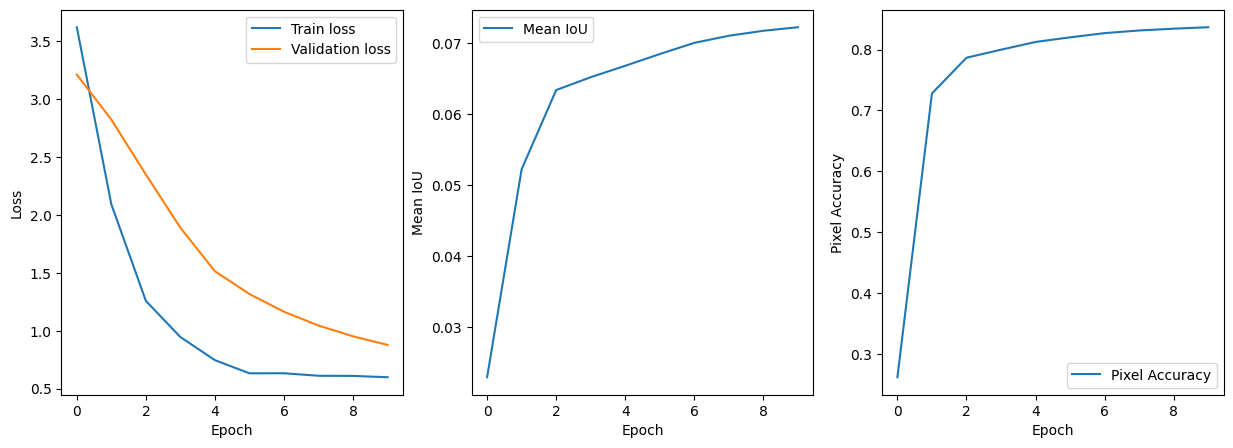

Best Mean IoU: 0.0723

Best batch_size: 16 | Mean IoU: 0.07909079990544113

Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: RMSprop | Batch size: 16
  Scheduler: StepLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.StepLR'>, 'step_size': 5, 'gamma': 0.1}



100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 1/10
Train loss: 2.3901 | Validation loss: 2.7875
Mean IoU: 0.0575 | Pixel accuracy: 0.7361


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch 2/10
Train loss: 0.9757 | Validation loss: 1.8839
Mean IoU: 0.0588 | Pixel accuracy: 0.7700


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 3/10
Train loss: 0.6137 | Validation loss: 1.2148
Mean IoU: 0.0602 | Pixel accuracy: 0.7906


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 4/10
Train loss: 0.5056 | Validation loss: 0.8552
Mean IoU: 0.0651 | Pixel accuracy: 0.8151


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 5/10
Train loss: 0.4629 | Validation loss: 0.6621
Mean IoU: 0.0703 | Pixel accuracy: 0.8388


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 6/10
Train loss: 0.4526 | Validation loss: 0.5762
Mean IoU: 0.0730 | Pixel accuracy: 0.8487


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch 7/10
Train loss: 0.4310 | Validation loss: 0.5192
Mean IoU: 0.0755 | Pixel accuracy: 0.8596


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 8/10
Train loss: 0.4303 | Validation loss: 0.4759
Mean IoU: 0.0774 | Pixel accuracy: 0.8682


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 9/10
Train loss: 0.4130 | Validation loss: 0.4528
Mean IoU: 0.0779 | Pixel accuracy: 0.8704


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 10/10
Train loss: 0.4255 | Validation loss: 0.4406
Mean IoU: 0.0782 | Pixel accuracy: 0.8719
Training time: 156.77 seconds


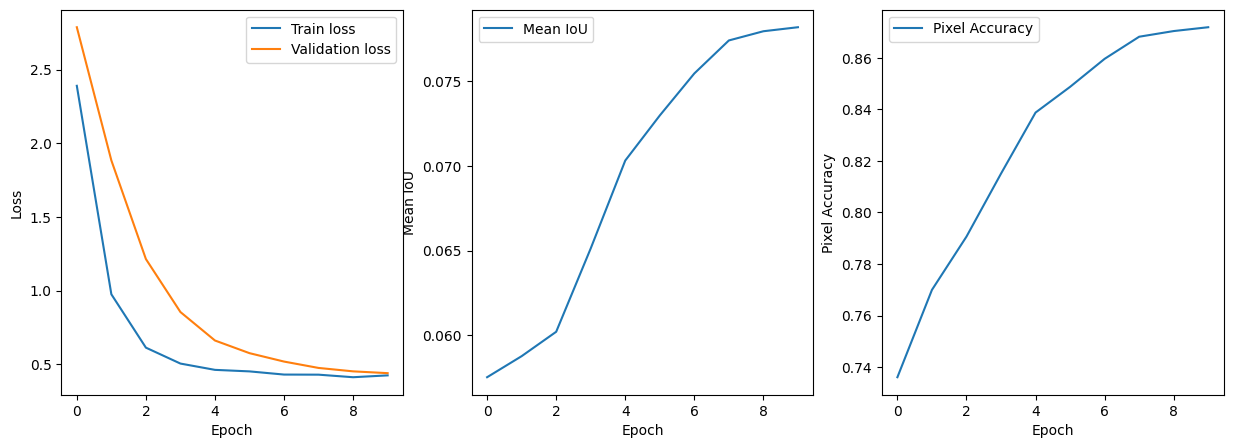

Best Mean IoU: 0.0782
Training and evaluating pspnet with the following hyperparameters:
  Encoder: resnet50 | Weights: imagenet | Activation: None
  Learning rate: 0.0001 | Optimizer: RMSprop | Batch size: 16
  Scheduler: ExponentialLR | Params: {'scheduler': <class 'torch.optim.lr_scheduler.ExponentialLR'>, 'gamma': 0.95}



100%|██████████| 6/6 [00:13<00:00,  2.30s/it]


Epoch 1/10
Train loss: 2.4246 | Validation loss: 2.8120
Mean IoU: 0.0252 | Pixel accuracy: 0.6158


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 2/10
Train loss: 1.0101 | Validation loss: 1.9494
Mean IoU: 0.0410 | Pixel accuracy: 0.7174


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 3/10
Train loss: 0.6719 | Validation loss: 1.3102
Mean IoU: 0.0508 | Pixel accuracy: 0.7604


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 4/10
Train loss: 0.5221 | Validation loss: 0.9524
Mean IoU: 0.0603 | Pixel accuracy: 0.8010


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch 5/10
Train loss: 0.4534 | Validation loss: 0.7101
Mean IoU: 0.0718 | Pixel accuracy: 0.8521


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch 6/10
Train loss: 0.4361 | Validation loss: 0.6031
Mean IoU: 0.0757 | Pixel accuracy: 0.8646


100%|██████████| 6/6 [00:12<00:00,  2.02s/it]


Epoch 7/10
Train loss: 0.4310 | Validation loss: 0.5388
Mean IoU: 0.0785 | Pixel accuracy: 0.8714


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch 8/10
Train loss: 0.4331 | Validation loss: 0.4949
Mean IoU: 0.0800 | Pixel accuracy: 0.8750


100%|██████████| 6/6 [00:12<00:00,  2.04s/it]


Epoch 9/10
Train loss: 0.4493 | Validation loss: 0.4646
Mean IoU: 0.0802 | Pixel accuracy: 0.8771


100%|██████████| 6/6 [00:12<00:00,  2.01s/it]


Epoch 10/10
Train loss: 0.4300 | Validation loss: 0.4489
Mean IoU: 0.0812 | Pixel accuracy: 0.8778
Training time: 155.45 seconds


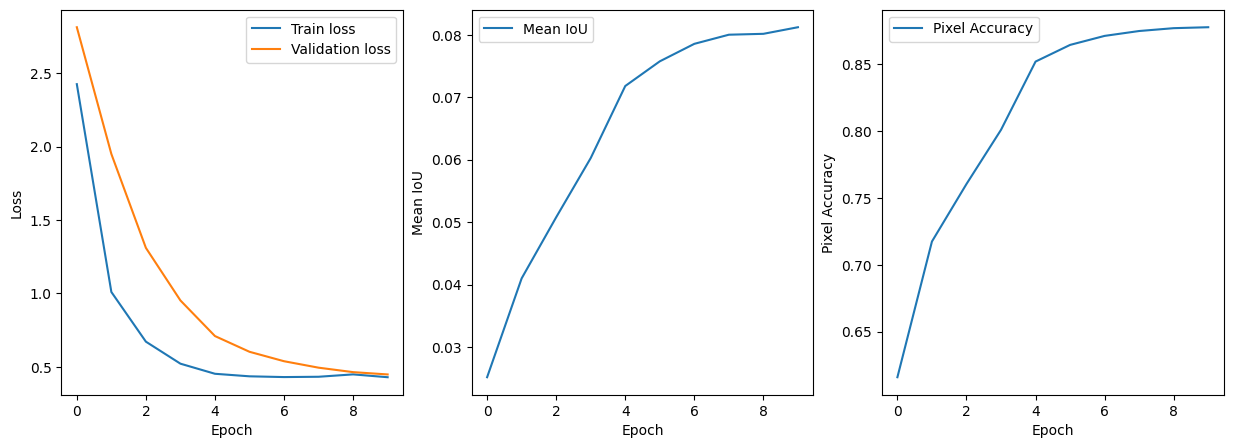

Best Mean IoU: 0.0812

Best scheduler: {'scheduler': <class 'torch.optim.lr_scheduler.ExponentialLR'>, 'gamma': 0.95} | Mean IoU: 0.08120795301857389


Best performance for pspnet
Encoder: resnet50 | Weights: imagenet | Activation: None
Learning rate: 0.0001 | Optimizer: RMSprop | Batch size: 16
Scheduler: ExponentialLR | Mean IoU: 0.08120795301857389


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch 1/10
Train loss: 2.7307 | Validation loss: 3.1938
Mean IoU: 0.0305 | Pixel accuracy: 0.2355


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 2/10
Train loss: 1.1270 | Validation loss: 2.4109
Mean IoU: 0.0613 | Pixel accuracy: 0.7312


100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


Epoch 3/10
Train loss: 0.6908 | Validation loss: 1.6918
Mean IoU: 0.0674 | Pixel accuracy: 0.7999


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 4/10
Train loss: 0.5569 | Validation loss: 1.1911
Mean IoU: 0.0726 | Pixel accuracy: 0.8370


100%|██████████| 6/6 [00:13<00:00,  2.20s/it]


Epoch 5/10
Train loss: 0.4961 | Validation loss: 0.8515
Mean IoU: 0.0760 | Pixel accuracy: 0.8558


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch 6/10
Train loss: 0.4464 | Validation loss: 0.6797
Mean IoU: 0.0778 | Pixel accuracy: 0.8666


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch 7/10
Train loss: 0.4296 | Validation loss: 0.5782
Mean IoU: 0.0784 | Pixel accuracy: 0.8686


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch 8/10
Train loss: 0.4446 | Validation loss: 0.5077
Mean IoU: 0.0786 | Pixel accuracy: 0.8695


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch 9/10
Train loss: 0.4351 | Validation loss: 0.4755
Mean IoU: 0.0784 | Pixel accuracy: 0.8676


100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


Epoch 10/10
Train loss: 0.4241 | Validation loss: 0.4548
Mean IoU: 0.0783 | Pixel accuracy: 0.8679
Training time: 154.72 seconds


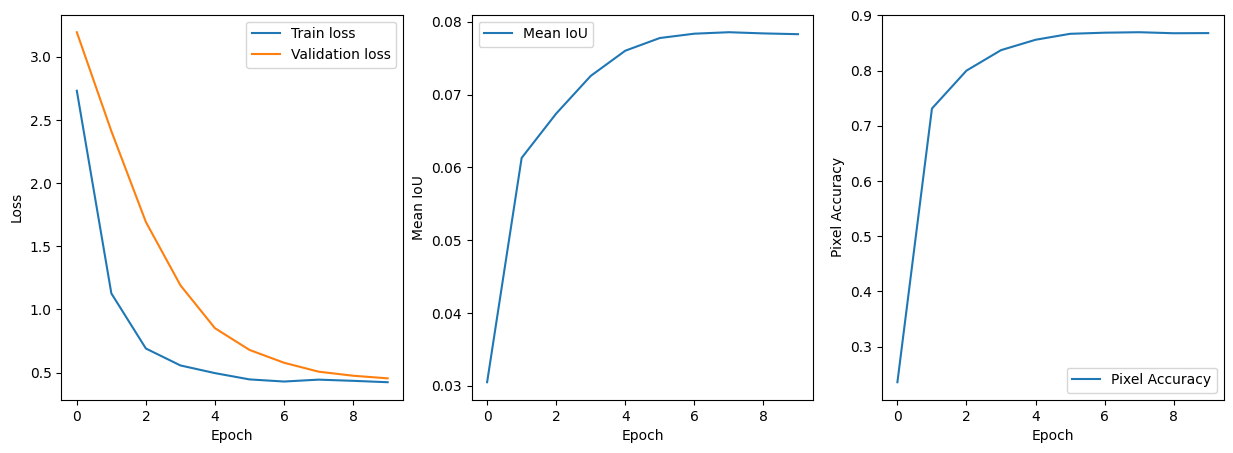

Best Mean IoU: 0.0786


In [ ]:
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epochs = 10

    model_info_list = [
        {"name": "pspnet", "model": smp.PSPNet}
    ]

    best_parameters_list = [] 

    for model_info in model_info_list:

        best_parameters = {
            "encoder_name": "resnet50",
            "encoder_weights": None,
            "activation": None,
            "learning_rate": 1e-4,
            "optimizer": optim.Adam,
            "batch_size": 16,
            "scheduler": {"scheduler": optim.lr_scheduler.StepLR, "step_size": 5, "gamma": 0.1},
            "mean_iou": 0
        }

        # Hyperparameters to explore
        encoder_names = ['resnet50', 'resnet101']
        encoder_weights = [None, 'imagenet']
        activation_functions = [None, 'sigmoid', 'softmax2d']
        learning_rates = [1e-4, 5e-5]
        optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
        batch_sizes = [16, 32]
        scheduler_options = [
            {"scheduler": optim.lr_scheduler.StepLR, "step_size": 5, "gamma": 0.1},
            {"scheduler": optim.lr_scheduler.ExponentialLR, "gamma": 0.95}
        ]

        hyperparameter_lists = [
            ("encoder_name", encoder_names),
            ("encoder_weights", encoder_weights),
            ("activation", activation_functions),
            ("learning_rate", learning_rates),
            ("optimizer", optimizers),
            ("batch_size", batch_sizes),
            ("scheduler", scheduler_options)
        ]

        for hyperparameter_name, hyperparameter_values in hyperparameter_lists:
            best_hyperparameter_value = None
            best_hyperparameter_iou = 0

            for hyperparameter_value in hyperparameter_values:
                current_parameters = best_parameters.copy()
                current_parameters[hyperparameter_name] = hyperparameter_value

                print(f"Training and evaluating {model_info['name']} with the following hyperparameters:")
                print(f"  Encoder: {current_parameters['encoder_name']} | Weights: {current_parameters['encoder_weights']} | Activation: {current_parameters['activation']}")
                print(f"  Learning rate: {current_parameters['learning_rate']} | Optimizer: {current_parameters['optimizer'].__name__} | Batch size: {current_parameters['batch_size']}")
                print(f"  Scheduler: {current_parameters['scheduler']['scheduler'].__name__} | Params: {current_parameters['scheduler']}\n")

                model = model_info["model"](encoder_name=current_parameters["encoder_name"],
                                             encoder_weights=current_parameters["encoder_weights"],
                                             classes=32,
                                             activation=current_parameters["activation"]).to(device)

                train_loader = DataLoader(train_dataset, batch_size=current_parameters["batch_size"], shuffle=True, num_workers=2)
                val_loader = DataLoader(val_dataset, batch_size=current_parameters["batch_size"], shuffle=False, num_workers=2)

                mean_iou = train_and_evaluate(model, train_loader, val_loader, epochs,
                                              current_parameters["learning_rate"],
                                              current_parameters["optimizer"],
                                              device, model_info["name"],
                                              current_parameters["scheduler"])

                if mean_iou > best_hyperparameter_iou:
                    best_hyperparameter_iou = mean_iou
                    best_hyperparameter_value = hyperparameter_value

            best_parameters[hyperparameter_name] = best_hyperparameter_value
            best_parameters["mean_iou"] = best_hyperparameter_iou
            print(f"\nBest {hyperparameter_name}: {best_hyperparameter_value} | Mean IoU: {best_hyperparameter_iou}\n")

        print("\nBest performance for", model_info["name"])
        print(f"Encoder: {best_parameters['encoder_name']} | Weights: {best_parameters['encoder_weights']} | Activation: {best_parameters['activation']}")
        print(f"Learning rate: {best_parameters['learning_rate']} | Optimizer: {best_parameters['optimizer'].__name__} | Batch size: {best_parameters['batch_size']}")
        print(f"Scheduler: {best_parameters['scheduler']['scheduler'].__name__} | Mean IoU: {best_parameters['mean_iou']}")

        # Train the model with the best hyperparameters
        model = model_info["model"](encoder_name=best_parameters["encoder_name"],
                                     encoder_weights=best_parameters["encoder_weights"],
                                     classes=32,
                                     activation=best_parameters["activation"]).to(device)

        train_loader = DataLoader(train_dataset, batch_size=best_parameters["batch_size"], shuffle=True, num_workers=2)
        val_loader = DataLoader(val_dataset, batch_size=best_parameters["batch_size"], shuffle=False, num_workers=2)

        train_and_evaluate(model, train_loader, val_loader, epochs,
                           best_parameters["learning_rate"],
                           best_parameters["optimizer"],
                           device, model_info["name"],
                           best_parameters["scheduler"])

        # Save the model state dict
        torch.save(model.state_dict(), f"best_model_{model_info['name']}.pth")

        # Add the best parameters for the model to the list
        best_parameters["name"] = model_info["name"]
        best_parameters_list.append(best_parameters.copy())

    # Return the list of best parameters
    return best_parameters_list


if __name__ == "__main__":
    best_parameters_list_pspnet = main()

    with open('best_parameters_list_pspnet.pkl', 'wb') as f:
        pickle.dump(best_parameters_list_pspnet, f)

6. Test the models on the testing dataset

In [12]:
with open('best_parameters_list_unet.pkl', 'rb') as f:
    best_parameters_list_unet = pickle.load(f)

with open('best_parameters_list_fpn.pkl', 'rb') as f:
    best_parameters_list_fpn = pickle.load(f)

with open('best_parameters_list_pspnet.pkl', 'rb') as f:
    best_parameters_list_pspnet = pickle.load(f)



def get_model_with_best_parameters(model_class, best_parameters_list):
    # Access the first dictionary in the list
    best_parameters = best_parameters_list[0]
    
    return model_class(encoder_name=best_parameters["encoder_name"],
                       encoder_weights=best_parameters["encoder_weights"],
                       in_channels=3,
                       classes=32,
                       activation=best_parameters["activation"])


models = {
    "Unet": {
        "model": get_model_with_best_parameters(smp.Unet, best_parameters_list_unet),
        "state_dict": "best_model_unet.pth"
    },
    "FPN": {
        "model": get_model_with_best_parameters(smp.FPN, best_parameters_list_fpn),
        "state_dict": "best_model_fpn.pth"
    },
    "PSPNet": {
        "model": get_model_with_best_parameters(smp.PSPNet, best_parameters_list_pspnet),
        "state_dict": "best_model_pspnet.pth"
    }
}



for model_name, model_data in models.items():
    print(f"\nTesting {model_name}")
    best_model = model_data["model"]
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_model.load_state_dict(torch.load(model_data["state_dict"], map_location=device))
    best_model.to(device)
    best_model.eval()

    test_losses = []
    mean_ious = []
    pixel_accuracies = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        running_test_loss = 0.0
        n_classes = 32
        confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = best_model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()

            # Calculate mean IoU and pixel accuracy
            pred = outputs.detach().max(1)[1].cpu().numpy()
            gt = labels.cpu().numpy()

            for p, t in zip(pred, gt):
                mask = (t >= 0) & (t < n_classes)
                confusion_matrix += np.bincount(n_classes * t[mask].astype(int) + p[mask], minlength=n_classes ** 2).reshape(n_classes, n_classes)

        test_losses.append(running_test_loss / len(test_loader))

        intersection = np.diag(confusion_matrix)
        union = confusion_matrix.sum(axis=1) + confusion_matrix.sum(axis=0) - intersection
        iou = intersection / (union + 1e-8)
        pixel_acc = intersection.sum() / confusion_matrix.sum()

        mean_ious.append(np.nanmean(iou))
        pixel_accuracies.append(np.nanmean(pixel_acc))

        print(f'Test loss: {test_losses[-1]:.4f}')
        print(f'Mean IoU: {mean_ious[-1]:.4f} | Pixel accuracy: {pixel_accuracies[-1]:.4f}')


Testing Unet
Test loss: 3.2366
Mean IoU: 0.0691 | Pixel accuracy: 0.5999

Testing FPN
Test loss: 0.3563
Mean IoU: 0.0948 | Pixel accuracy: 0.8960

Testing PSPNet
Test loss: 0.4035
Mean IoU: 0.0851 | Pixel accuracy: 0.8853
